In [1]:
pip install plotly sklearn nbformat notebook ipywidgets

Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN

In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import plotly.graph_objects as go

# data

In [ ]:
DAY = 0

In [178]:
def get_prices(round: int, day: int):

    path = f"../../data/round{round}/prices_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"../../data/round{round}/trades_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")

price_frames = []
trade_frames = []

for day in range(1, 2):  

    prices = get_prices(2, day)
    trades = get_trades(2, day)
    price_frames.append(prices)
    trade_frames.append(trades)

df = pd.concat(price_frames, ignore_index=True)
all_trades = pd.concat(trade_frames, ignore_index=True)
df

day  timestamp           product  bid_price_1  bid_volume_1  \
0        1          0         SQUID_INK         1834            23   
1        1          0    PICNIC_BASKET1        58705            12   
2        1          0    PICNIC_BASKET2        30252            12   
3        1          0  RAINFOREST_RESIN         9992            31   
4        1          0              KELP         2032            23   
...    ...        ...               ...          ...           ...   
79995    1     999900              JAMS         6519           204   
79996    1     999900  RAINFOREST_RESIN         9992            34   
79997    1     999900         SQUID_INK         1880            20   
79998    1     999900    PICNIC_BASKET1        58713            15   
79999    1     999900    PICNIC_BASKET2        30100            36   

       bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0              NaN           NaN          NaN           NaN         1838   
1          58704.0          27.0          NaN           NaN        58716   
2          30251.0          27.0          NaN           NaN        30258   
3              NaN           NaN          NaN           NaN        10008   
4              NaN           NaN          NaN           NaN         2035   
...            ...           ...          ...           ...          ...   
79995          NaN           NaN          NaN           NaN         6521   
79996          NaN           NaN          NaN           NaN        10008   
79997          NaN           NaN          NaN           NaN         1884   
79998      58712.0          21.0          NaN           NaN        58724   
79999          NaN           NaN          NaN           NaN        30107   

       ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0                23          NaN           NaN          NaN           NaN   
1                12      58717.0          27.0          NaN           NaN   
2                39          NaN           NaN          NaN           NaN   
3                31          NaN           NaN          NaN           NaN   
4                23          NaN           NaN          NaN           NaN   
...             ...          ...           ...          ...           ...   
79995           204          NaN           NaN          NaN           NaN   
79996            34          NaN           NaN          NaN           NaN   
79997            20          NaN           NaN          NaN           NaN   
79998            15      58725.0          21.0          NaN           NaN   
79999            36          NaN           NaN          NaN           NaN   

       mid_price  profit_and_loss  
0         1836.0              0.0  
1        58710.5              0.0  
2        30255.0              0.0  
3        10000.0              0.0  
4         2033.5              0.0  
...          ...              ...  
79995     6520.0              0.0  
79996    10000.0              0.0  
79997     1882.0              0.0  
79998    58718.5              0.0  
79999    30103.5              0.0  

[80000 rows x 17 columns]

In [180]:
def swmid(row):
    bid = row['bid_price_1']
    ask = row['ask_price_1']
    bid_volume = row['bid_volume_1']
    ask_volume = row['ask_volume_1']
    return ((bid*ask_volume + ask*bid_volume)/(bid_volume + ask_volume))

def mm_mid_basket(row, volume_cutoff=10):
    # Find the best bid with volume >= volume_cutoff
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= volume_cutoff:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        # No bid with sufficient volume found
        best_bid = None

    # Find the best ask with volume >= volume_cutoff
    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= volume_cutoff:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        # No ask with sufficient volume found
        best_ask = None

    # Calculate the mid-price if both best bid and best ask are found
    if best_bid is not None and best_ask is not None:
        mid_price = (best_bid + best_ask) / 2
        return mid_price
    else:
        # Return the mid_price column value as default
        return row['mid_price']
    

In [182]:
def fair_price(row):
    if row['product'] == 'PICNIC_BASKET1' or row['product'] == 'PICNIC_BASKET2':
        return mm_mid_basket(row, volume_cutoff=10)
    else:
        return swmid(row)

df['fair'] = df.apply(fair_price, axis=1)

In [183]:
df

day  timestamp           product  bid_price_1  bid_volume_1  \
0        1          0         SQUID_INK         1834            23   
1        1          0    PICNIC_BASKET1        58705            12   
2        1          0    PICNIC_BASKET2        30252            12   
3        1          0  RAINFOREST_RESIN         9992            31   
4        1          0              KELP         2032            23   
...    ...        ...               ...          ...           ...   
79995    1     999900              JAMS         6519           204   
79996    1     999900  RAINFOREST_RESIN         9992            34   
79997    1     999900         SQUID_INK         1880            20   
79998    1     999900    PICNIC_BASKET1        58713            15   
79999    1     999900    PICNIC_BASKET2        30100            36   

       bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0              NaN           NaN          NaN           NaN         1838   
1          58704.0          27.0          NaN           NaN        58716   
2          30251.0          27.0          NaN           NaN        30258   
3              NaN           NaN          NaN           NaN        10008   
4              NaN           NaN          NaN           NaN         2035   
...            ...           ...          ...           ...          ...   
79995          NaN           NaN          NaN           NaN         6521   
79996          NaN           NaN          NaN           NaN        10008   
79997          NaN           NaN          NaN           NaN         1884   
79998      58712.0          21.0          NaN           NaN        58724   
79999          NaN           NaN          NaN           NaN        30107   

       ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0                23          NaN           NaN          NaN           NaN   
1                12      58717.0          27.0          NaN           NaN   
2                39          NaN           NaN          NaN           NaN   
3                31          NaN           NaN          NaN           NaN   
4                23          NaN           NaN          NaN           NaN   
...             ...          ...           ...          ...           ...   
79995           204          NaN           NaN          NaN           NaN   
79996            34          NaN           NaN          NaN           NaN   
79997            20          NaN           NaN          NaN           NaN   
79998            15      58725.0          21.0          NaN           NaN   
79999            36          NaN           NaN          NaN           NaN   

       mid_price  profit_and_loss     fair  
0         1836.0              0.0   1836.0  
1        58710.5              0.0  58710.5  
2        30255.0              0.0  30255.0  
3        10000.0              0.0  10000.0  
4         2033.5              0.0   2033.5  
...          ...              ...      ...  
79995     6520.0              0.0   6520.0  
79996    10000.0              0.0  10000.0  
79997     1882.0              0.0   1882.0  
79998    58718.5              0.0  58718.5  
79999    30103.5              0.0  30103.5  

[80000 rows x 18 columns]

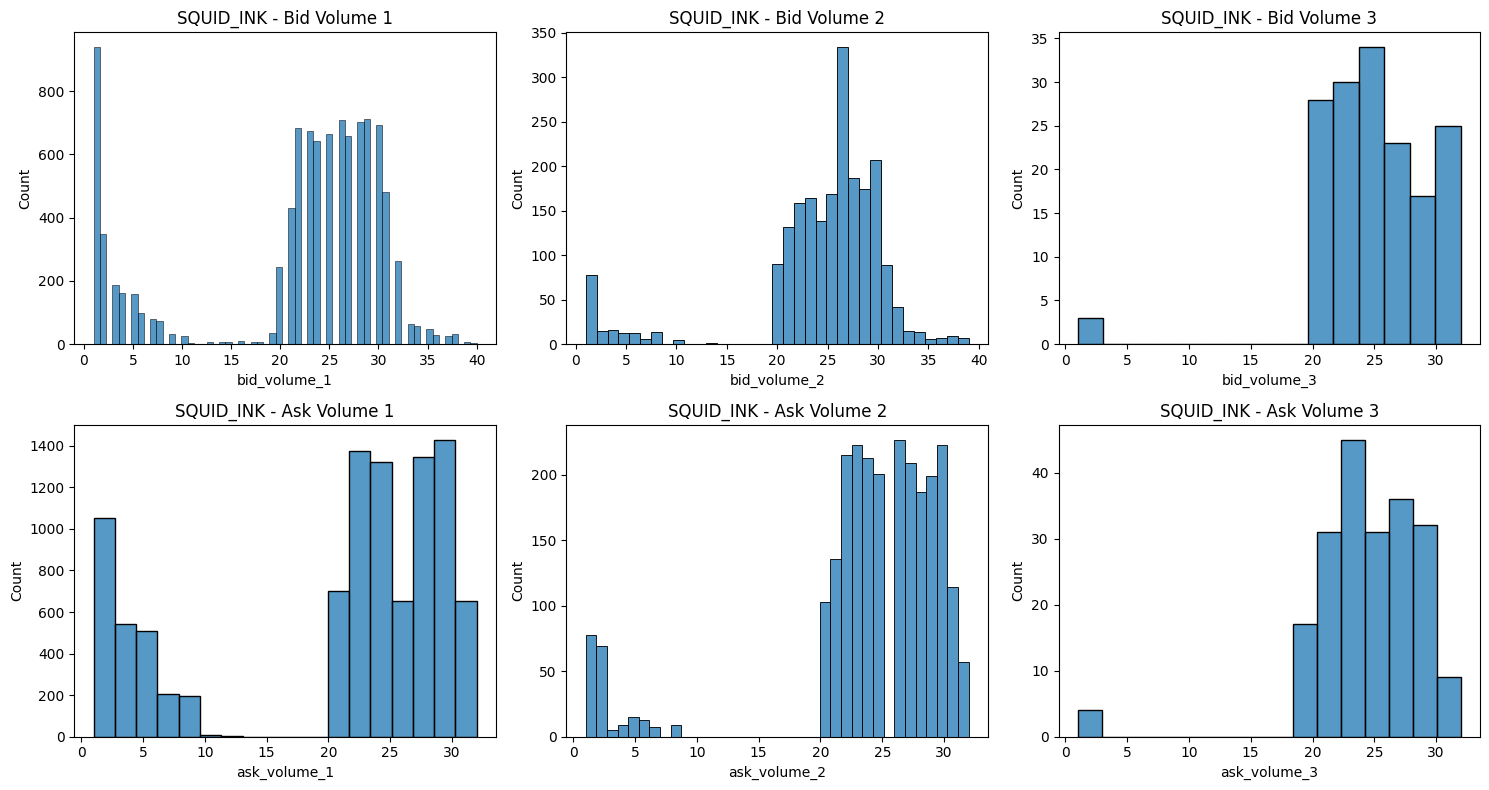

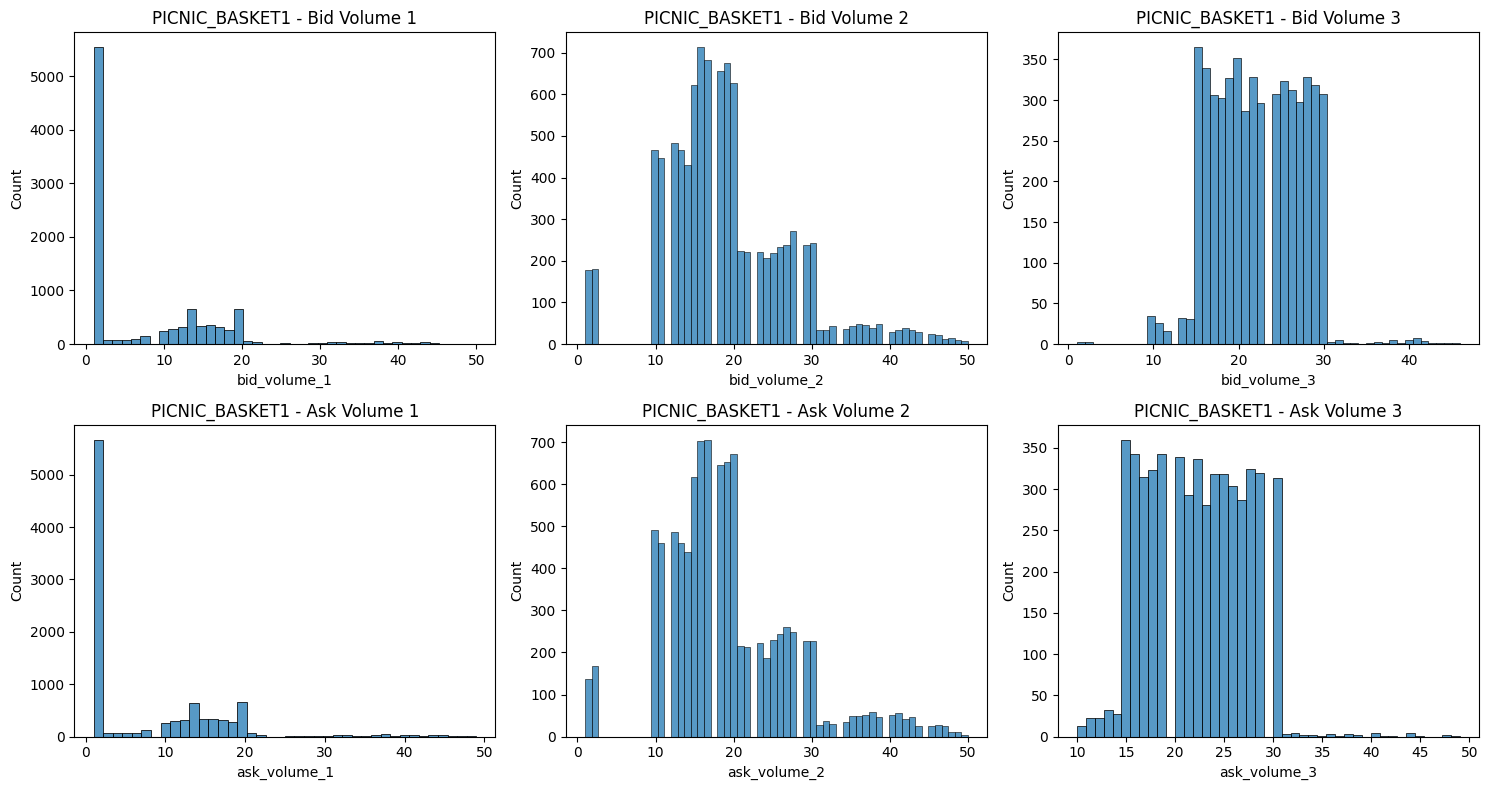

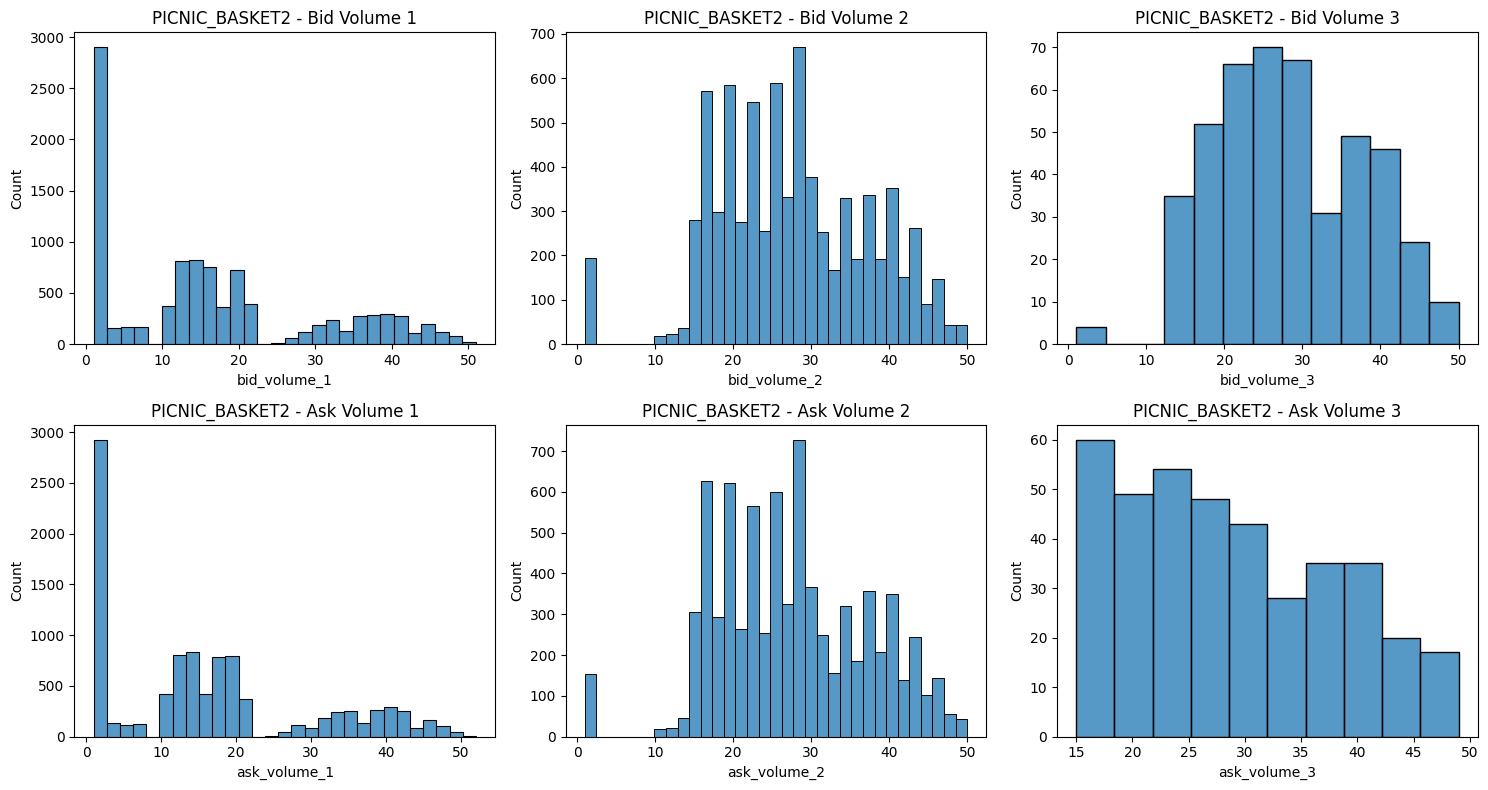

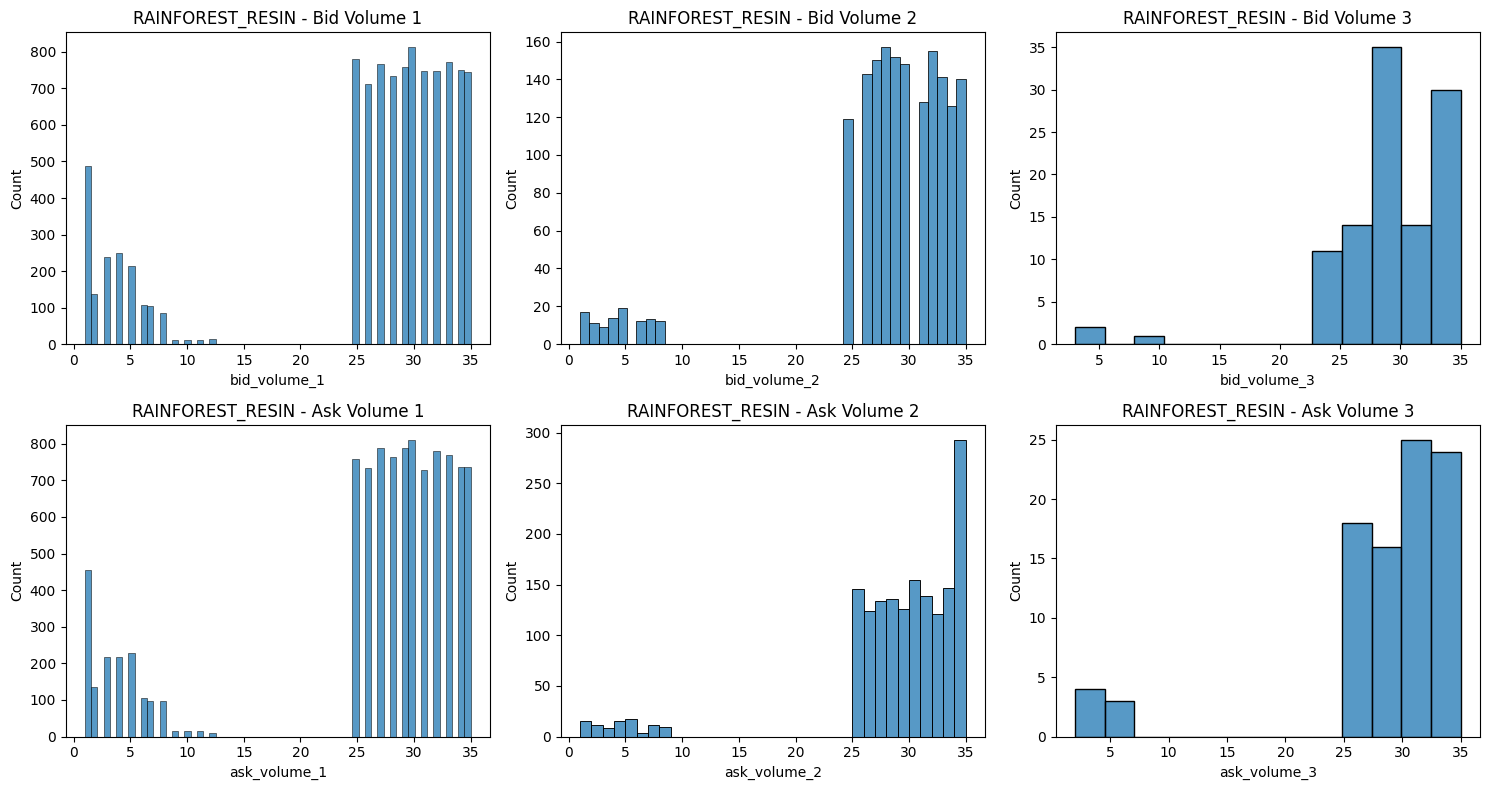

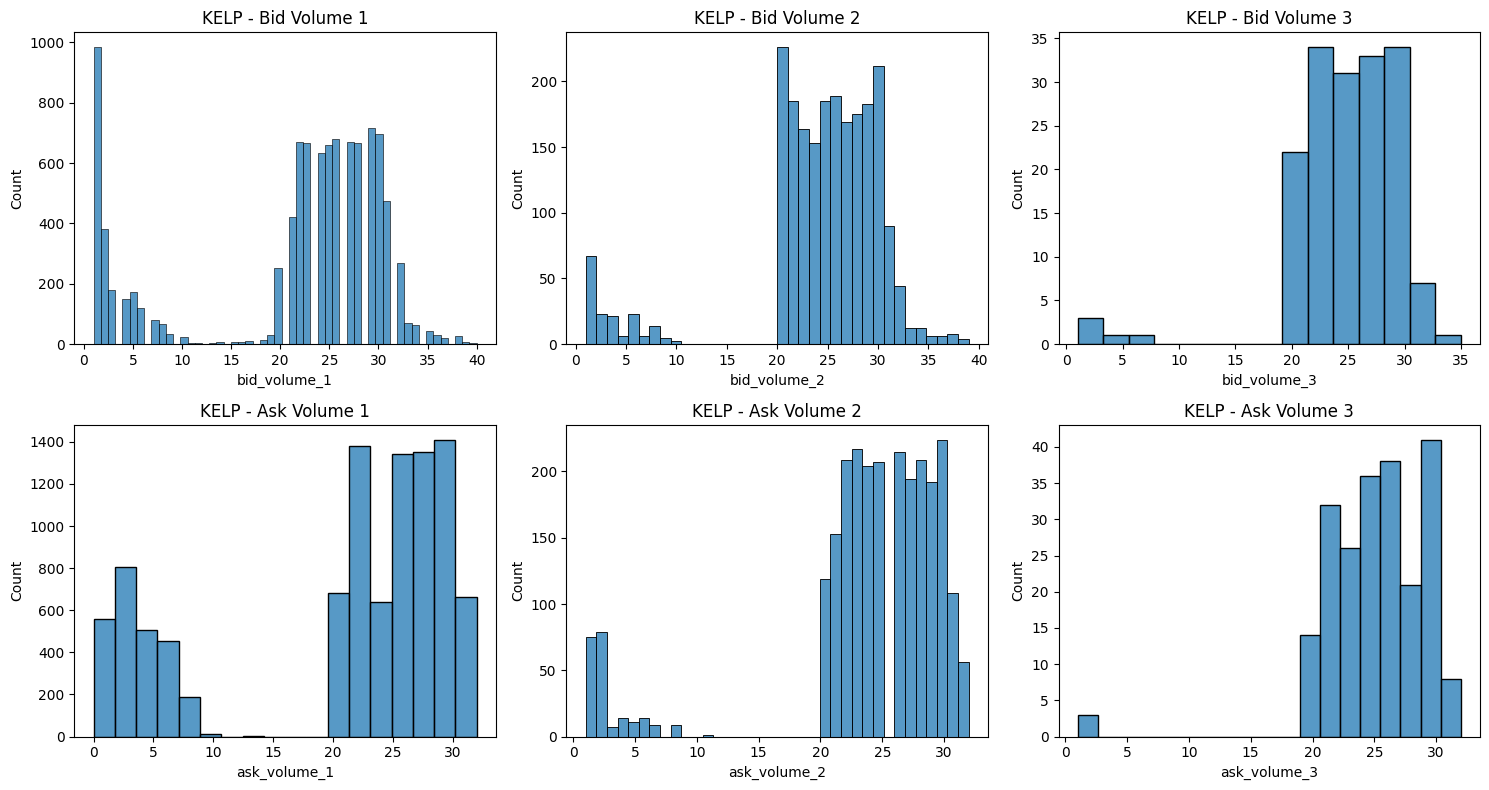

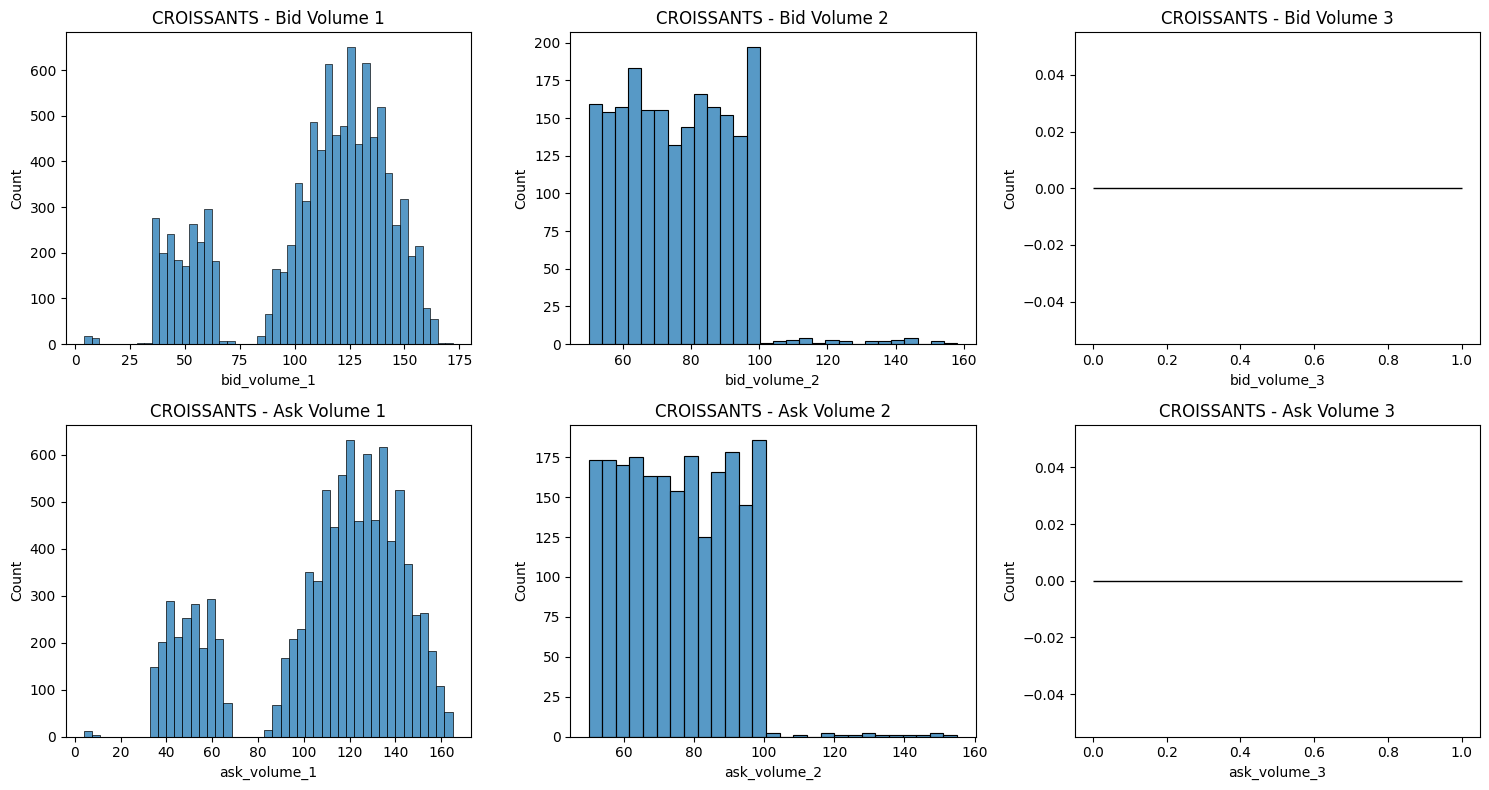

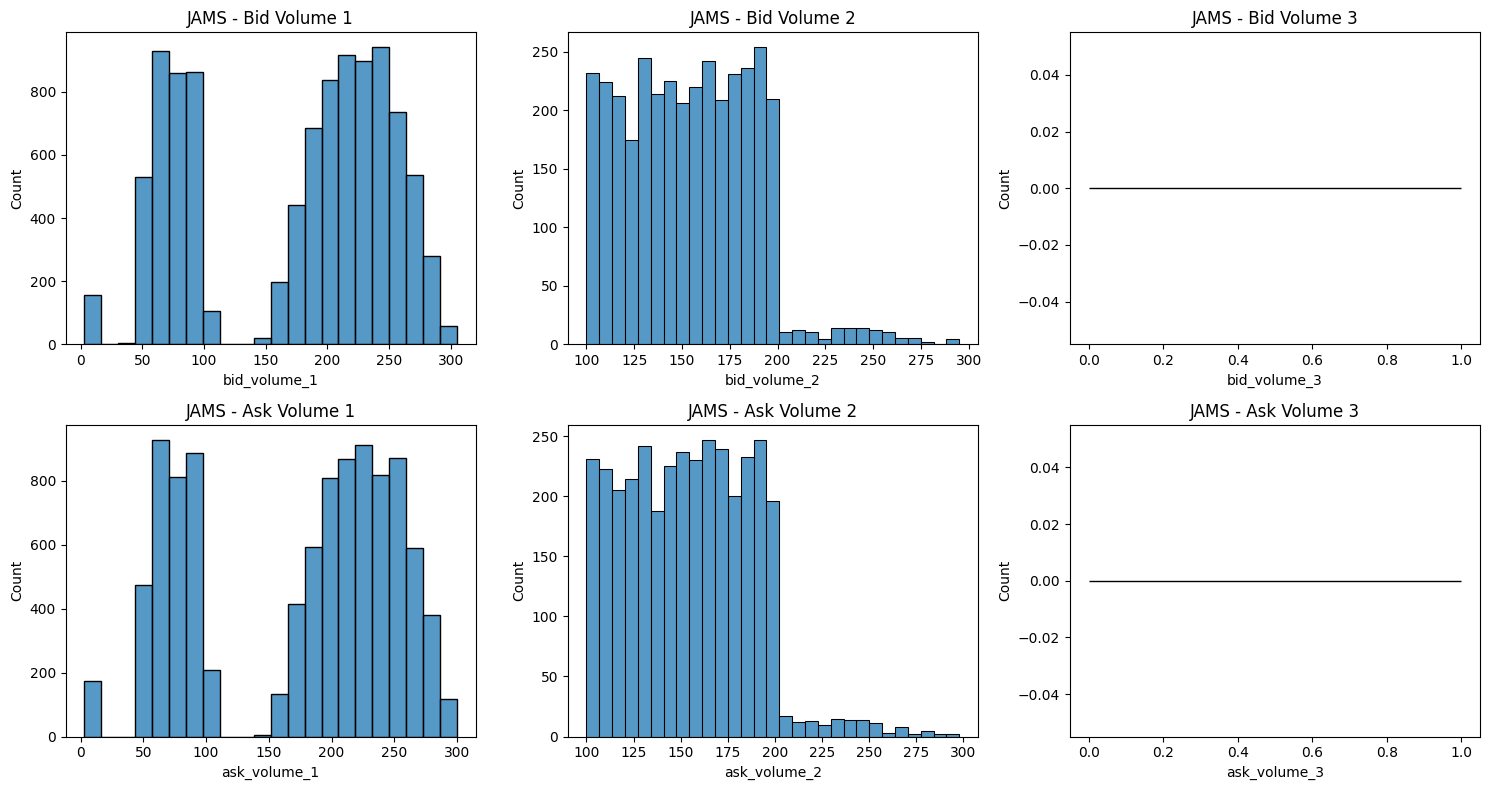

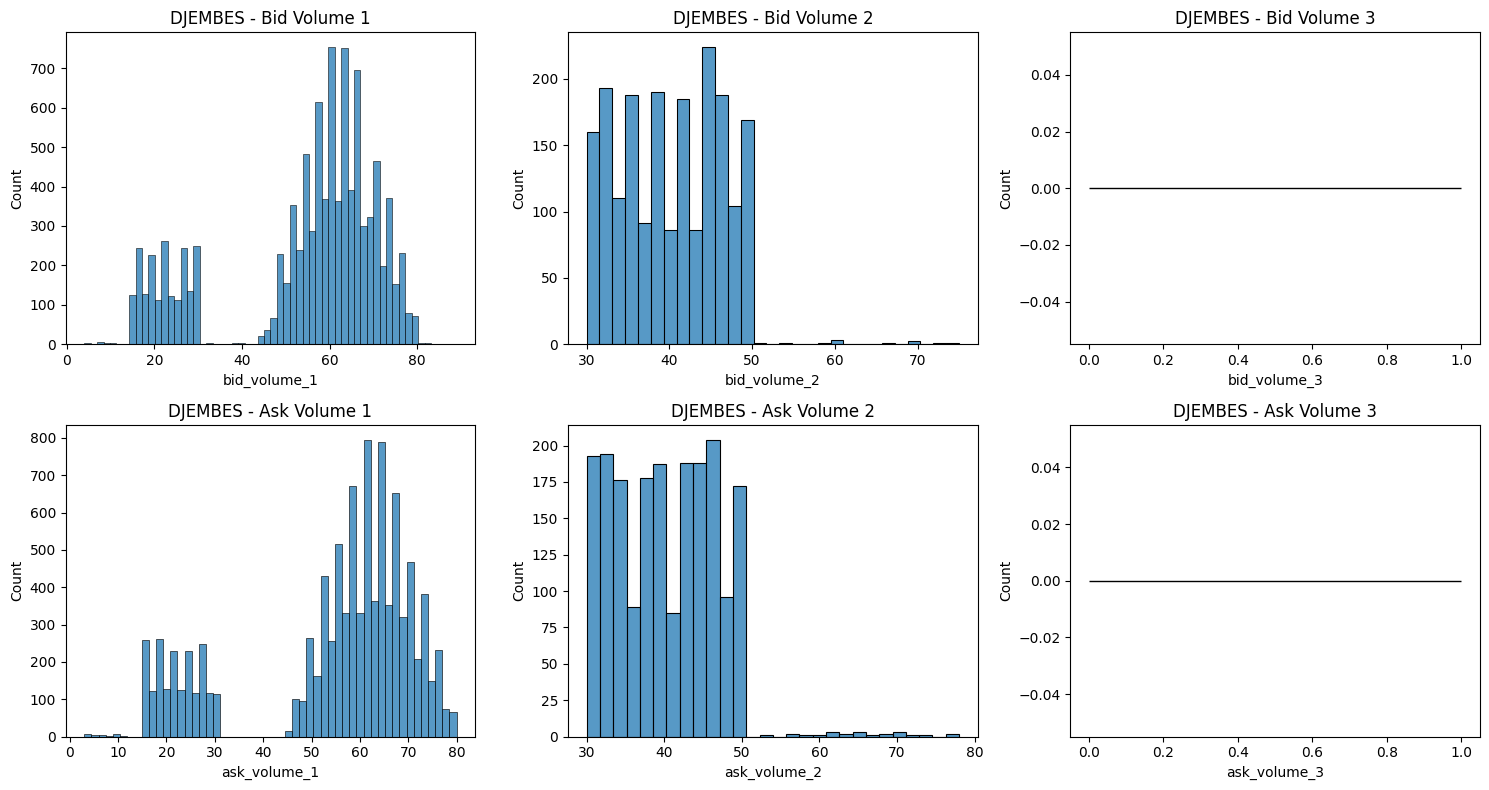

In [186]:
# Get the unique products
unique_products = df['product'].unique()

for product in unique_products:
    # Filter the dataframe for the current product
    product_df = df[df['product'] == product]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Plot bid volume histograms
    sns.histplot(data=product_df, x='bid_volume_1', ax=axes[0, 0])
    sns.histplot(data=product_df, x='bid_volume_2', ax=axes[0, 1])
    sns.histplot(data=product_df, x='bid_volume_3', ax=axes[0, 2])
    
    # Plot ask volume histograms
    sns.histplot(data=product_df, x='ask_volume_1', ax=axes[1, 0])
    sns.histplot(data=product_df, x='ask_volume_2', ax=axes[1, 1])
    sns.histplot(data=product_df, x='ask_volume_3', ax=axes[1, 2])
    
    # Set titles for subplots
    axes[0, 0].set_title(f"{product} - Bid Volume 1")
    axes[0, 1].set_title(f"{product} - Bid Volume 2")
    axes[0, 2].set_title(f"{product} - Bid Volume 3")
    axes[1, 0].set_title(f"{product} - Ask Volume 1")
    axes[1, 1].set_title(f"{product} - Ask Volume 2")
    axes[1, 2].set_title(f"{product} - Ask Volume 3")
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [187]:
weights1 = {
    'CROISSANTS': 6,
    'JAMS': 3,
    'DJEMBES': 1
}
weights2 = {
    'CROISSANTS': 4,
    'JAMS': 2,
}

def compute_synthetic(group):
    def weighted_price(weights):
        bid = sum(
            group[group['product'] == p]['bid_price_1'].iloc[0] * w
            for p, w in weights.items()
            if p in group['product'].values
        )
        ask = sum(
            group[group['product'] == p]['ask_price_1'].iloc[0] * w
            for p, w in weights.items()
            if p in group['product'].values
        )
        return bid, ask

    syn1_bid, syn1_ask = weighted_price(weights1)
    syn2_bid, syn2_ask = weighted_price(weights2)

    return pd.Series({
        'synthetic1_bid': syn1_bid,
        'synthetic1_ask': syn1_ask,
        'synthetic2_bid': syn2_bid,
        'synthetic2_ask': syn2_ask,
    })

synthetic_df = df.groupby('timestamp', as_index=False).apply(compute_synthetic).reset_index(drop=True)

merged_df = pd.merge(df, synthetic_df, on='timestamp')


/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_77764/431370320.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  synthetic_df = df.groupby('timestamp', as_index=False).apply(compute_synthetic).reset_index(drop=True)


In [188]:
# Get the unique product names
products = df['product'].unique()

# Create a new dataframe 'df_fairs' with the desired columns
columns = ['timestamp'] + list(products) + ['SYNTHETIC1', 'SYNTHETIC2']
df_fairs = pd.DataFrame(columns=columns)

# Iterate over unique timestamps in the original dataframe
for timestamp in df['timestamp'].unique():
    # Get the rows for the current timestamp
    rows = df[df['timestamp'] == timestamp]
    
    # Create a dictionary to store the fair values for each product
    fairs = {}
    
    # Iterate over each product and extract its fair value
    for product in products:
        fair = rows.loc[rows['product'] == product, 'fair'].values[0]
        fairs[product] = fair
    
    # Calculate the synthetic fair
    synthetic_fair1 = sum(fairs[product] * weights1.get(product, 0) for product in ['CROISSANTS','JAMS','DJEMBES'])
    synthetic_fair2 = sum(fairs[product] * weights2.get(product, 0) for product in ['CROISSANTS','JAMS'])
    
    new_row = {
        'timestamp': timestamp,
        **{product: fairs[product] for product in products},
        'SYNTHETIC1': synthetic_fair1,
        'SYNTHETIC2': synthetic_fair2
    }
    
    # Append the new row to df_fairs
    df_fairs = pd.concat([df_fairs, pd.DataFrame([new_row])], ignore_index=True)

# Reset the index of df_fairs (optional)
df_fairs = df_fairs.reset_index(drop=True)

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_77764/2906553254.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fairs = pd.concat([df_fairs, pd.DataFrame([new_row])], ignore_index=True)


In [189]:
df_pairs = merged_df[merged_df['product'].isin(['PICNIC_BASKET1', 'PICNIC_BASKET2'])]


In [190]:
df_pairs.loc[:, 'implied_mid1'] = ((df_pairs['synthetic1_bid'] + df_pairs['synthetic1_ask'])/2)
df_pairs.loc[:, 'implied_mid2'] = ((df_pairs['synthetic2_bid'] + df_pairs['synthetic2_ask'])/2)

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_77764/3481320028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pairs.loc[:, 'implied_mid1'] = ((df_pairs['synthetic1_bid'] + df_pairs['synthetic1_ask'])/2)
/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_77764/3481320028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pairs.loc[:, 'implied_mid2'] = ((df_pairs['synthetic2_bid'] + df_pairs['synthetic2_ask'])/2)


In [191]:
basket1_df = df_pairs[df_pairs['product'] == 'PICNIC_BASKET1']
spread_mean = (basket1_df['mid_price'] - basket1_df['implied_mid1']).mean()
print(spread_mean)

32.3198


In [192]:
spread_std = (basket1_df['mid_price'] - basket1_df['implied_mid1']).std()
print(spread_std)

89.17652983440944


In [193]:
basket2_df = df_pairs[df_pairs['product'] == 'PICNIC_BASKET2']
spread_mean = (basket2_df['mid_price'] - basket2_df['implied_mid2']).mean()
print(spread_mean)

36.46695


In [194]:
spread_std = (basket2_df['mid_price'] - basket2_df['implied_mid2']).std()
print(spread_std)

55.1431995802156


## boellinger band

In [196]:
df_fairs = df_fairs[['timestamp', 'CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'SYNTHETIC1', 'PICNIC_BASKET2', 'SYNTHETIC2']]

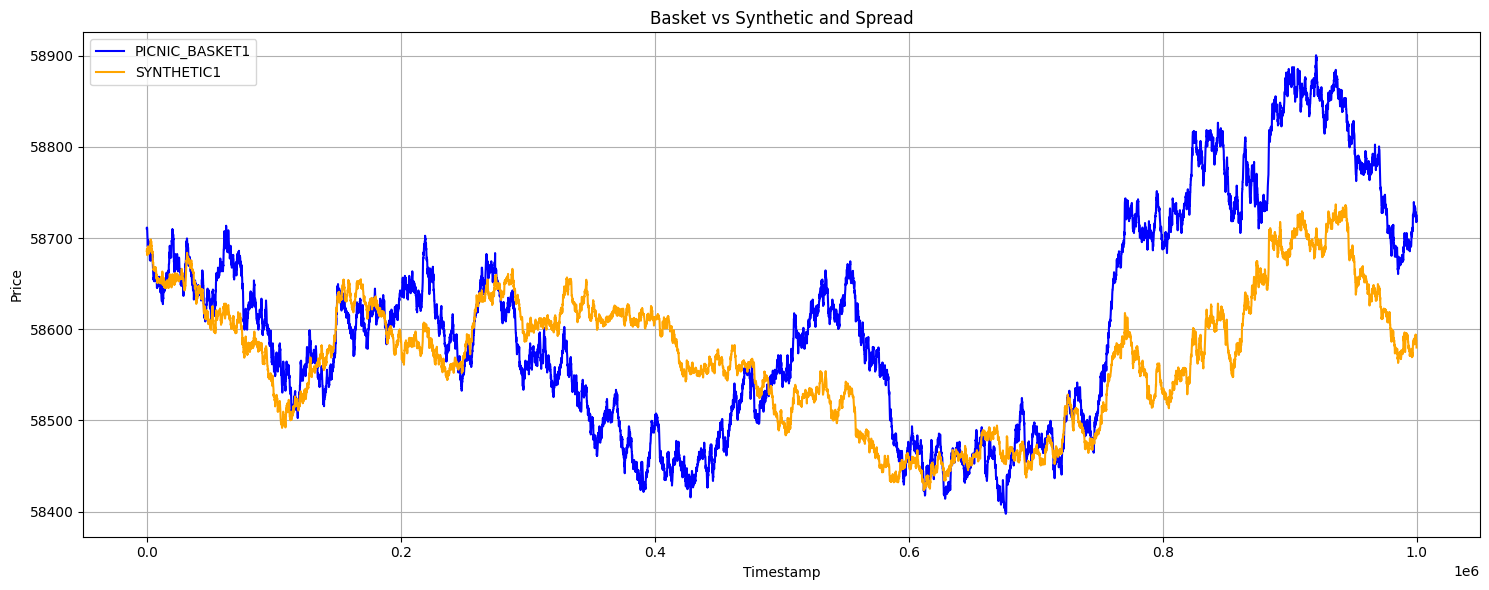

In [198]:
plt.figure(figsize=(15, 6))

plt.plot(df_fairs['timestamp'], df_fairs['PICNIC_BASKET1'], label='PICNIC_BASKET1', color='blue')
plt.plot(df_fairs['timestamp'], df_fairs['SYNTHETIC1'], label='SYNTHETIC1', color='orange')

plt.title('Basket vs Synthetic and Spread')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


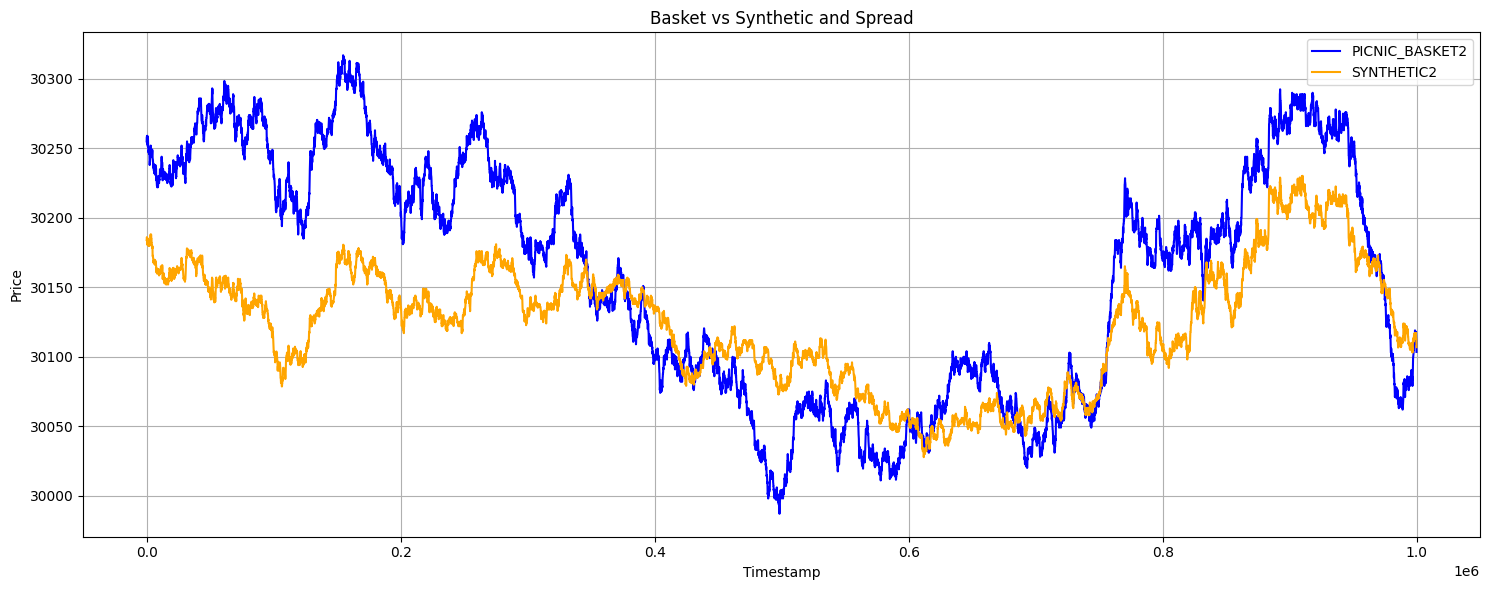

In [199]:
plt.figure(figsize=(15, 6))

plt.plot(df_fairs['timestamp'], df_fairs['PICNIC_BASKET2'], label='PICNIC_BASKET2', color='blue')
plt.plot(df_fairs['timestamp'], df_fairs['SYNTHETIC2'], label='SYNTHETIC2', color='orange')

plt.title('Basket vs Synthetic and Spread')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [157]:
df_fairs['BASKET1_MINUS_SYNTHETIC'] = df_fairs['PICNIC_BASKET1'] - df_fairs["SYNTHETIC1"]
df_fairs['BASKET2_MINUS_SYNTHETIC'] = df_fairs['PICNIC_BASKET2'] - df_fairs["SYNTHETIC2"]

In [158]:
default_spread_mean = df_fairs['BASKET1_MINUS_SYNTHETIC'].mean()
default_spread_std = df_fairs['BASKET1_MINUS_SYNTHETIC'].std()

print("default_spread_mean_1:", default_spread_mean)
print("default_spread_std_1:", default_spread_std)

default_spread_mean_1: 43.911801631683
default_spread_std_1: 82.74471733844537


In [159]:
default_spread_mean = df_fairs['BASKET2_MINUS_SYNTHETIC'].mean()
default_spread_std = df_fairs['BASKET2_MINUS_SYNTHETIC'].std()

print("default_spread_mean_2:", default_spread_mean)
print("default_spread_std_2:", default_spread_std)

default_spread_mean_2: -3.8353725218940906
default_spread_std_2: 55.11959512748779


In [160]:
def bollinger_bands(data, column, basket_number, window=20, num_std=2):
    """
    Calculate Bollinger Bands for a given DataFrame and column.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to calculate Bollinger Bands for.
    window (int): The rolling window size for the Simple Moving Average (SMA).
    num_std (int): The number of standard deviations for the upper and lower bands.
    
    Returns:
    pd.DataFrame: The input DataFrame with additional columns for the Bollinger Bands.
    """
    # Calculate the Simple Moving Average (SMA)
    data[f'SMA_{basket_number}'] = data[column].rolling(window=window).mean()
    
    # Calculate the standard deviation
    data[f'STD_{basket_number}'] = data[column].rolling(window=window).std()
    
    # Calculate the upper and lower Bollinger Bands
    data[f'UPPER_BAND_{basket_number}'] = data[f'SMA_{basket_number}'] + (data[f'STD_{basket_number}'] * num_std)
    data[f'LOWER_BAND_{basket_number}'] = data[f'SMA_{basket_number}'] - (data[f'STD_{basket_number}'] * num_std)
    
    return data

# Example usage
df_fairs = bollinger_bands(df_fairs, column='BASKET1_MINUS_SYNTHETIC', window=200, num_std=1.5, basket_number=1)
df_fairs = bollinger_bands(df_fairs, column='BASKET2_MINUS_SYNTHETIC', window=200, num_std=1.5, basket_number=2)

# Calculate the change in STD
df_fairs['STD_CHANGE_1'] = df_fairs['STD_1'].diff()
df_fairs['STD_CHANGE_2'] = df_fairs['STD_2'].diff()

In [161]:
df_fairs

timestamp   CROISSANTS    JAMS       DJEMBES  PICNIC_BASKET1  \
0            0  4321.500000  6632.0  13493.500000         59228.5   
1          100  4321.738693  6631.5  13493.000000         59228.5   
2          200  4321.741463  6632.0  13493.256098         59232.0   
3          300  4321.500000  6632.0  13493.295918         59228.5   
4          400  4321.500000  6632.0  13493.287356         59230.5   
...        ...          ...     ...           ...             ...   
9995    999500  4275.500000  6541.0  13410.500000         58717.5   
9996    999600  4275.708571  6541.0  13410.724638         58722.5   
9997    999700  4275.718750  6541.0  13411.000000         58722.5   
9998    999800  4275.500000  6541.5  13409.000000         58715.5   
9999    999900  4275.500000  6542.0  13409.500000         58720.5   

        SYNTHETIC1  PICNIC_BASKET2    SYNTHETIC2  BASKET1_MINUS_SYNTHETIC  \
0     59318.500000         30505.0  30550.000000               -90.000000   
1     59317.932161         30504.0  30549.954774               -89.432161   
2     59319.704878         30505.0  30550.965854               -87.704878   
3     59318.295918         30501.5  30550.000000               -89.795918   
4     59318.287356         30505.5  30550.000000               -87.787356   
...            ...             ...           ...                      ...   
9995  58686.500000         30254.0  30184.000000                31.000000   
9996  58687.976066         30254.5  30184.834286                34.523934   
9997  58688.312500         30255.0  30184.875000                34.187500   
9998  58686.500000         30255.0  30185.000000                29.000000   
9999  58688.500000         30257.0  30186.000000                32.000000   

      BASKET2_MINUS_SYNTHETIC      SMA_1      STD_1  UPPER_BAND_1  \
0                  -45.000000        NaN        NaN           NaN   
1                  -45.954774        NaN        NaN           NaN   
2                  -45.965854        NaN        NaN           NaN   
3                  -48.500000        NaN        NaN           NaN   
4                  -44.500000        NaN        NaN           NaN   
...                       ...        ...        ...           ...   
9995                70.000000  40.780561  15.070040     63.385621   
9996                69.665714  40.616883  14.958362     63.054426   
9997                70.125000  40.452682  14.846819     62.722911   
9998                70.000000  40.262007  14.746965     62.382454   
9999                71.000000  40.068752  14.599241     61.967614   

      LOWER_BAND_1       SMA_2      STD_2  UPPER_BAND_2  LOWER_BAND_2  \
0              NaN         NaN        NaN           NaN           NaN   
1              NaN         NaN        NaN           NaN           NaN   
2              NaN         NaN        NaN           NaN           NaN   
3              NaN         NaN        NaN           NaN           NaN   
4              NaN         NaN        NaN           NaN           NaN   
...            ...         ...        ...           ...           ...   
9995     18.175501  101.413134  19.966156    131.362368     71.463900   
9996     18.179340  101.112264  19.989011    131.095781     71.128747   
9997     18.182453  100.813732  20.003787    130.819412     70.808051   
9998     18.141559  100.504164  19.999154    130.502895     70.505433   
9999     18.169891  100.198661  19.980740    130.169770     70.227551   

      STD_CHANGE_1  STD_CHANGE_2  
0              NaN           NaN  
1              NaN           NaN  
2              NaN           NaN  
3              NaN           NaN  
4              NaN           NaN  
...            ...           ...  
9995     -0.083019      0.020859  
9996     -0.111678      0.022855  
9997     -0.111543      0.014776  
9998     -0.099854     -0.004633  
9999     -0.147724     -0.018414  

[10000 rows x 20 columns]

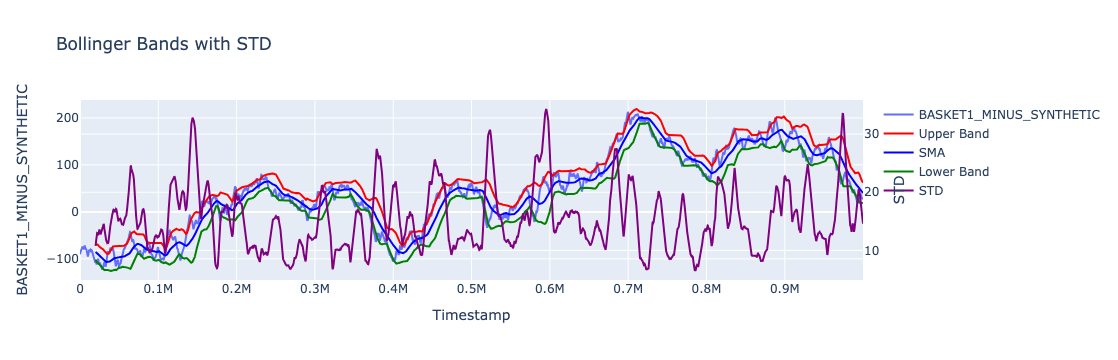

In [126]:
# Create the plot
fig = go.Figure()

# Add the BASKET_MINUS_SYNTHETIC line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['BASKET1_MINUS_SYNTHETIC'].ewm(halflife=5).mean(),
                         mode='lines', name='BASKET1_MINUS_SYNTHETIC'))

# Add the Upper Bollinger Band line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['UPPER_BAND_1'],
                         mode='lines', name='Upper Band', line=dict(color='red')))

# Add the Simple Moving Average (SMA) line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['SMA_1'],
                         mode='lines', name='SMA', line=dict(color='blue')))

# Add the Lower Bollinger Band line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['LOWER_BAND_1'],
                         mode='lines', name='Lower Band', line=dict(color='green')))

# Add the change in STD line on a separate y-axis
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['STD_1'],
                         mode='lines', name='STD', line=dict(color='purple'),
                         yaxis='y2'))

# Update the layout to include the secondary y-axis
fig.update_layout(
    title='Bollinger Bands with STD',
    xaxis_title='Timestamp',
    yaxis=dict(title='BASKET1_MINUS_SYNTHETIC'),
    yaxis2=dict(title='STD', overlaying='y', side='right')
)

# Display the plot
fig.show()

In [127]:
# Create the plot
fig = go.Figure()

# Add the BASKET_MINUS_SYNTHETIC line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['BASKET2_MINUS_SYNTHETIC'].ewm(halflife=5).mean(),
                         mode='lines', name='BASKET2_MINUS_SYNTHETIC'))

# Add the Upper Bollinger Band line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['UPPER_BAND_2'],
                         mode='lines', name='Upper Band', line=dict(color='red')))

# Add the Simple Moving Average (SMA) line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['SMA_2'],
                         mode='lines', name='SMA', line=dict(color='blue')))

# Add the Lower Bollinger Band line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['LOWER_BAND_2'],
                         mode='lines', name='Lower Band', line=dict(color='green')))

# Add the change in STD line on a separate y-axis
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['STD_2'],
                         mode='lines', name='STD', line=dict(color='purple'),
                         yaxis='y2'))

# Update the layout to include the secondary y-axis
fig.update_layout(
    title='Bollinger Bands with STD',
    xaxis_title='Timestamp',
    yaxis=dict(title='BASKET2_MINUS_SYNTHETIC'),
    yaxis2=dict(title='STD', overlaying='y', side='right')
)

# Display the plot
fig.show()

In [129]:
def identify_regime_1(data, mean=370, lookback=20, ewma=0):
    """
    Identify the regime based on the price's interaction with Bollinger Bands.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing Bollinger Bands.
    lookback (int): The lookback period to determine the regime.

    Returns:
    pd.Series: A series containing the identified regime for each row.
    """
    price = data['BASKET1_MINUS_SYNTHETIC']
    if ewma != 0: 
        price = data['BASKET1_MINUS_SYNTHETIC'].ewm(halflife=ewma).mean()
    upper = data['UPPER_BAND_1']
    lower = data['LOWER_BAND_1']

    # Create a rolling window of size lookback
    rolling_window = price.rolling(window=lookback)

    # Check if price is above upper band or below lower band
    above_upper = (price >= upper).rolling(window=lookback).sum()
    below_lower = (price <= lower).rolling(window=lookback).sum()

    # Count contiguous touches of upper and lower bands
    touched_upper = (above_upper > 1).astype(int)
    touched_lower = (below_lower > 1).astype(int)

    # Assign regimes based on the touched bands
    regimes = pd.Series(index=data.index, dtype='object')
    regimes.loc[(touched_upper == 1) & (touched_lower == 1)] = 'OSCILLATING'
    regimes.loc[(touched_upper == 1) & (touched_lower == 0)] = 'RIDING_UPPER'
    regimes.loc[(touched_upper == 0) & (touched_lower == 1)] = 'RIDING_LOWER'
    regimes.fillna('NEUTRAL', inplace=True)

    # Fill the initial lookback period with 'NEUTRAL'
    regimes.iloc[:lookback] = 'NEUTRAL'

    return regimes

# Apply the identify_regime function to your DataFrame
df_fairs['REGIME'] = identify_regime_1(df_fairs, mean=df_fairs['BASKET1_MINUS_SYNTHETIC'].mean(), lookback=400, ewma=5)

In [130]:
def generate_signals_1(data, mean_price):
    """
    Generate trading signals based on the identified regimes and Bollinger Bands.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing Bollinger Bands and regimes.
    mean_price (float): The mean price to compare against when entering riding regimes.

    Returns:
    pd.Series: A series containing the generated trading signals for each row.
    """
    price = data['BASKET1_MINUS_SYNTHETIC']
    upper = data['UPPER_BAND_1']
    lower = data['LOWER_BAND_1']
    regime = data['REGIME']

    signals = pd.Series(index=data.index, dtype=object)

    for i in tqdm(range(1, len(data))):
        if regime[i] == 'OSCILLATING':
            if price[i] >= upper[i] and price[i-1] < upper[i-1]:
                signals[i] = 'SHORT'
            elif i < len(data) - 1 and price[i] >= upper[i] and price[i+1] < upper[i+1]:
                signals[i] = "SHORT"
            elif price[i] <= lower[i] and price[i-1] > lower[i-1]:
                signals[i] = 'LONG'
            elif i < len(data) - 1 and price[i] <= lower[i] and price[i+1] > lower[i+1]:
                signals[i] = 'LONG'
        elif regime[i] == 'NEUTRAL' and regime[i-1] != 'NEUTRAL':
            signals[i] = 'CLEAR'
        elif regime[i] == 'RIDING_UPPER' and regime[i-1] != 'RIDING_UPPER':
            if price[i] > mean_price:
                signals[i] = 'CLEAR'
            else:
                signals[i] = 'LONG'
        elif regime[i] == 'RIDING_LOWER' and regime[i-1] != 'RIDING_LOWER':
            if price[i] < mean_price:
                signals[i] = 'CLEAR'
            else:
                signals[i] = 'SHORT'

    return signals

df_fairs['SIGNAL'] = generate_signals_1(df_fairs, df_fairs['BASKET1_MINUS_SYNTHETIC'].mean())

100%|██████████| 9999/9999 [00:00<00:00, 104585.39it/s]


In [48]:
fig = go.Figure()

# Add the BASKET_MINUS_SYNTHETIC line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['BASKET_MINUS_SYNTHETIC'],
                         mode='lines', name='BASKET_MINUS_SYNTHETIC'))

# Add the Upper Bollinger Band line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['UPPER_BAND'],
                         mode='lines', name='Upper Band', line=dict(color='red')))

# Add the Simple Moving Average (SMA) line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['SMA'],
                         mode='lines', name='SMA', line=dict(color='blue')))

# Add the Lower Bollinger Band line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['LOWER_BAND'],
                         mode='lines', name='Lower Band', line=dict(color='green')))

# Find regime switch points
regime_switch_points = df_fairs[df_fairs['REGIME'] != df_fairs['REGIME'].shift(1)]

# Add vertical lines for regime switches
for _, row in regime_switch_points.iterrows():
    fig.add_shape(type='line',
                  x0=row['timestamp'], y0=df_fairs['BASKET_MINUS_SYNTHETIC'].min(),
                  x1=row['timestamp'], y1=df_fairs['BASKET_MINUS_SYNTHETIC'].max(),
                  line=dict(color='black', width=1, dash='dash'))
    
    # Add hover text for regime switches
    fig.add_trace(go.Scatter(x=[row['timestamp']], y=[df_fairs.loc[row.name, 'BASKET_MINUS_SYNTHETIC']],
                             mode='markers', marker=dict(size=0), hoverinfo='text',
                             text=f"Regime: {row['REGIME']}<br>Last Sell Signal: {row['SIGNAL']}"))

# Update the layout
fig.update_layout(title='Bollinger Bands with Regime Switches',
                  xaxis_title='Timestamp',
                  yaxis_title='BASKET_MINUS_SYNTHETIC')

# Display the plot
fig.show()

## backtest

In [49]:
df_fairs['SIGNAL'].value_counts()

SIGNAL
SHORT    202
LONG     160
CLEAR      8
Name: count, dtype: int64

In [18]:
def update_position(signals):
    """
    Update the position based on the last non-nan signal.
    
    Parameters:
    signals (pd.Series): The series containing the trading signals.
    
    Returns:
    pd.Series: A series containing the updated positions.
    """
    last_signal = None
    positions = []
    
    for signal in signals:
        if pd.notna(signal):
            last_signal = signal
        
        if last_signal == 'LONG':
            position = 60
        elif last_signal == 'SHORT':
            position = -60
        else:
            position = 0
        
        positions.append(position)
    
    return pd.Series(positions, index=signals.index)

# Update the position based on the trading signals
df_fairs['POSITION'] = update_position(df_fairs['SIGNAL'])

In [19]:
# Initialize the "CASH" column with zeros
df_fairs['CASH'] = 0

# Calculate the position differences
df_fairs['POSITION_DIFF'] = df_fairs['POSITION'].diff().fillna(0)

# Update the "CASH" column based on position changes
df_fairs['CASH'] = -df_fairs['POSITION_DIFF'] * df_fairs['BASKET_MINUS_SYNTHETIC']

# Calculate the cumulative cash
df_fairs['CUMULATIVE_CASH'] = df_fairs['CASH'].cumsum()

df_fairs['PNL'] = df_fairs['CUMULATIVE_CASH'] + df_fairs['POSITION'] * df_fairs["BASKET_MINUS_SYNTHETIC"]

In [20]:
df_fairs[df_fairs['POSITION_DIFF'] != 0]

timestamp   CROISSANTS         JAMS       DJEMBES  PICNIC_BASKET1  \
406      40600  4321.687861  6633.500000  13490.227848         59244.5   
452      45200  4323.500000  6632.000000  13485.000000         59195.5   
556      55600  4324.500000  6634.000000  13479.000000         59258.5   
686      68600  4320.719512  6632.500000  13487.717949         59237.5   
856      85600  4322.500000  6624.000000  13486.000000         59229.5   
896      89600  4323.500000  6620.000000  13488.000000         59191.0   
1080    108000  4323.255208  6615.500000  13497.000000         59206.5   
1254    125400  4326.000000  6607.000000  13502.243590         59186.5   
1354    135400  4324.500000  6606.000000  13514.500000         59233.5   
1687    168700  4322.500000  6617.500000  13489.297872         59312.5   
1928    192800  4320.305164  6610.500000  13494.000000         59274.5   
2203    220300  4324.691358  6620.500000  13500.776119         59370.5   
2413    241300  4327.281407  6623.500000  13487.500000         59369.5   
2721    272100  4325.500000  6621.000000  13484.677419         59318.5   
3053    305300  4320.258993  6623.000000  13499.000000         59329.5   
3229    322900  4315.734043  6617.705686  13507.752941         59290.0   
3312    331200  4314.681592  6616.500000  13500.700000         59299.5   
3448    344800  4316.209581  6619.010033  13507.250000         59294.5   
3514    351400  4314.000000  6622.500000  13507.000000         59268.5   
4130    413000  4307.000000  6627.015789  13517.246377         59171.5   
4343    434300  4308.710938  6625.000000  13485.712766         59140.5   
4371    437100  4309.000000  6626.000000  13488.241379         59180.5   
4400    440000  4308.500000  6627.000000  13484.253968         59191.0   
4989    498900  4305.676923  6621.500000  13443.000000         59208.5   
5104    510400  4309.518519  6617.509934  13443.728261         59180.5   
5213    521300  4311.500000  6612.500000  13447.500000         59138.5   
5505    550500  4299.500000  6604.500000  13445.500000         59068.5   
5610    561000  4294.500000  6599.983051  13450.226667         59052.5   
5867    586700  4295.500000  6610.000000  13446.270270         59105.5   
6178    617800  4292.500000  6597.727273  13447.773333         59033.5   
6210    621000  4292.500000  6598.000000  13458.000000         59058.5   
6413    641300  4289.500000  6598.000000  13438.711111         59018.5   
6540    654000  4296.317073  6600.500000  13423.765957         59091.5   
6815    681500  4302.000000  6586.984127  13416.019608         59134.5   
7315    731500  4308.500000  6568.000000  13408.000000         59128.5   
7407    740700  4306.500000  6568.016667  13398.292929         59101.5   
8408    840800  4299.000000  6544.000000  13468.500000         59039.5   
8470    847000  4297.305195  6542.000000  13457.000000         58999.5   
8648    864800  4290.700000  6532.537415  13445.250000         58951.5   
8715    871500  4289.260274  6531.000000  13446.500000         58918.5   
8776    877600  4293.343195  6534.500000  13453.776471         58988.5   
8950    895000  4289.648810  6551.000000  13447.714286         58988.5   
9095    909500  4287.500000  6545.000000  13438.000000         58975.5   
9183    918300  4279.000000  6562.000000  13441.246154         58941.5   
9396    939600  4275.500000  6563.000000  13439.273810         58920.5   
9490    949000  4274.707763  6571.000000  13431.000000         58897.5   
9537    953700  4275.000000  6564.000000  13428.202381         58915.5   
9613    961300  4275.706667  6562.000000  13418.000000         58873.5   
9972    997200  4276.000000  6540.500000  13410.500000         58723.5   

         SYNTHETIC  BASKET_MINUS_SYNTHETIC         SMA        STD  UPPER_BAND  \
406   59320.855016              -76.355016 -101.686365  15.611266  -78.269466   
452   59322.000000             -126.500000  -98.293077  16.871479  -72.985858   
556   59328.000000              -69.500000  -95.205852  14.67

In [21]:
df_fairs['POSITION'].value_counts()

POSITION
-60    3858
 60    3493
 0     2649
Name: count, dtype: int64

In [22]:
import plotly.graph_objects as go

# Create the plot
fig = go.Figure()

# Add the CUMULATIVE_CASH line
fig.add_trace(go.Scatter(x=df_fairs['timestamp'], y=df_fairs['PNL'],
                         mode='lines', name='Cum'))

# Update the layout
fig.update_layout(title='Cumulative Cash Over Time',
                  xaxis_title='Timestamp',
                  yaxis_title='Cumulative Cash')

# Display the plot
fig.show()

# gridsearch

In [23]:
import itertools

def run_backtest(data, bb_window, bb_std, lookback):
    # Calculate Bollinger Bands
    data = bollinger_bands(data, window=bb_window, num_std=bb_std)

    # Identify the regime
    data['REGIME'] = identify_regime(data, mean=data['BASKET_MINUS_SYNTHETIC'].mean(), lookback=lookback)

    # Generate trading signals
    mean_price = data['BASKET_MINUS_SYNTHETIC'].mean()
    data['SIGNAL'] = generate_signals(data, mean_price)

    # Update the position based on the trading signals
    data['POSITION'] = update_position(data['SIGNAL'])

    # Initialize the "CASH" column with zeros
    data['CASH'] = 0

    # Calculate the position differences
    data['POSITION_DIFF'] = data['POSITION'].diff().fillna(0)

    # Update the "CASH" column based on position changes
    data['CASH'] = -data['POSITION_DIFF'] * data['BASKET_MINUS_SYNTHETIC']

    # Calculate the cumulative cash
    data['CUMULATIVE_CASH'] = data['CASH'].cumsum()

    # Calculate the PNL
    data['PNL'] = data['CUMULATIVE_CASH'] + data['POSITION'] * data["BASKET_MINUS_SYNTHETIC"]

    return data

# Define the arrays of candidate values for each parameter
bb_windows = [ 75, 100, 150, 200, 250, 300, 350, 400, 500]
bb_stds = [1.5,1.75, 2,2.25, 2.5]
lookbacks = [50,75,100, 125, 150, 175, 200]

# Perform the grid search
results = []
for bb_window, bb_std, lookback in itertools.product(bb_windows, bb_stds, lookbacks):
    # Run the backtest with the current parameter values
    data = run_backtest(df_fairs.copy(), bb_window, bb_std, lookback)

    # Get the final PNL
    final_pnl = data['PNL'].iloc[-1]

    # Store the results
    results.append({
        'bb_window': bb_window,
        'bb_std': bb_std,
        'lookback': lookback,
        'pnl': final_pnl
    })

    # Print the parameters and PNL for each iteration
    print(f"Bollinger Bands Window: {bb_window}, Bollinger Bands Std: {bb_std}, Lookback: {lookback}, PNL: {final_pnl}")

# Find the best parameters based on the highest PNL
best_result = max(results, key=lambda x: x['pnl'])
print("\nBest Parameters:")
print(f"Bollinger Bands Window: {best_result['bb_window']}")
print(f"Bollinger Bands Std: {best_result['bb_std']}")
print(f"Lookback: {best_result['lookback']}")
print(f"PNL: {best_result['pnl']}")

100%|██████████| 9999/9999 [00:00<00:00, 139359.03it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 14943.518905807869


100%|██████████| 9999/9999 [00:00<00:00, 146916.72it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 75, PNL: 2168.5480492928764


100%|██████████| 9999/9999 [00:00<00:00, 128072.80it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 100, PNL: -1211.2113702949136


100%|██████████| 9999/9999 [00:00<00:00, 116429.52it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 125, PNL: -12201.283714072342


100%|██████████| 9999/9999 [00:00<00:00, 112212.16it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 150, PNL: -12029.89675689736


100%|██████████| 9999/9999 [00:00<00:00, 102957.08it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 175, PNL: -8972.630837280303


100%|██████████| 9999/9999 [00:00<00:00, 102231.02it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.5, Lookback: 200, PNL: -11729.79250260716


100%|██████████| 9999/9999 [00:00<00:00, 173047.17it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 10358.956493340957


100%|██████████| 9999/9999 [00:00<00:00, 85626.35it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 9245.04776417627


100%|██████████| 9999/9999 [00:00<00:00, 135649.79it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 100, PNL: 3642.2991484982776


100%|██████████| 9999/9999 [00:00<00:00, 123749.91it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 125, PNL: -1760.9427261530072


100%|██████████| 9999/9999 [00:00<00:00, 117053.12it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 150, PNL: -6163.186626633396


100%|██████████| 9999/9999 [00:00<00:00, 113529.57it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 175, PNL: -3968.548491455731


100%|██████████| 9999/9999 [00:00<00:00, 110992.78it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 1.75, Lookback: 200, PNL: -494.44545510661555


100%|██████████| 9999/9999 [00:00<00:00, 190758.58it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 50, PNL: 11381.583055411029


100%|██████████| 9999/9999 [00:00<00:00, 174174.77it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 75, PNL: 11685.44428236637


100%|██████████| 9999/9999 [00:00<00:00, 153750.55it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 100, PNL: 8533.746640952595


100%|██████████| 9999/9999 [00:00<00:00, 140395.64it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 125, PNL: -2055.176699353906


100%|██████████| 9999/9999 [00:00<00:00, 109308.54it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 150, PNL: -3509.709212943708


100%|██████████| 9999/9999 [00:00<00:00, 122385.58it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 175, PNL: 4508.9362743805395


100%|██████████| 9999/9999 [00:00<00:00, 119133.28it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2, Lookback: 200, PNL: 5853.131492766843


100%|██████████| 9999/9999 [00:00<00:00, 102096.13it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 17090.31425445224


100%|██████████| 9999/9999 [00:00<00:00, 185311.01it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 4123.200036616763


100%|██████████| 9999/9999 [00:00<00:00, 169025.10it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 100, PNL: 6975.764252053632


100%|██████████| 9999/9999 [00:00<00:00, 161362.83it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 125, PNL: 16722.07802203702


100%|██████████| 9999/9999 [00:00<00:00, 152168.46it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 150, PNL: -2899.926254015736


100%|██████████| 9999/9999 [00:00<00:00, 143426.76it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 4243.977560302155


100%|██████████| 9999/9999 [00:00<00:00, 134695.68it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 15500.482741054584


100%|██████████| 9999/9999 [00:00<00:00, 194657.88it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 50, PNL: -1302.706995208282


100%|██████████| 9999/9999 [00:00<00:00, 191849.36it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 3798.73098423428


100%|██████████| 9999/9999 [00:00<00:00, 182682.76it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 100, PNL: 13688.82689762031


100%|██████████| 9999/9999 [00:00<00:00, 182560.29it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 125, PNL: 16641.147089880542


100%|██████████| 9999/9999 [00:00<00:00, 172114.00it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 150, PNL: 13020.448183614499


100%|██████████| 9999/9999 [00:00<00:00, 126478.02it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 175, PNL: 4098.6890314328775


100%|██████████| 9999/9999 [00:00<00:00, 157363.12it/s]


Bollinger Bands Window: 75, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 16627.485572087317


100%|██████████| 9999/9999 [00:00<00:00, 160672.92it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 18302.124809474917


100%|██████████| 9999/9999 [00:00<00:00, 107949.03it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 75, PNL: 5191.9286330424075


100%|██████████| 9999/9999 [00:00<00:00, 119211.84it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 100, PNL: 1766.0509934781294


100%|██████████| 9999/9999 [00:00<00:00, 118294.88it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 125, PNL: -6669.046771778521


100%|██████████| 9999/9999 [00:00<00:00, 113782.76it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 652.0134270231938


100%|██████████| 9999/9999 [00:00<00:00, 109007.10it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 3956.499824397324


100%|██████████| 9999/9999 [00:00<00:00, 105368.16it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 1688.1616130814655


100%|██████████| 9999/9999 [00:00<00:00, 185569.29it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 7211.969256394805


100%|██████████| 9999/9999 [00:00<00:00, 163939.53it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 12624.724275947374


100%|██████████| 9999/9999 [00:00<00:00, 146563.48it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 100, PNL: 9548.987117534416


100%|██████████| 9999/9999 [00:00<00:00, 132423.27it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 9633.624065592012


100%|██████████| 9999/9999 [00:00<00:00, 121556.59it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 14344.470862456947


100%|██████████| 9999/9999 [00:00<00:00, 75323.10it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 14750.226286190737


100%|██████████| 9999/9999 [00:00<00:00, 112816.17it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 10250.872345195821


100%|██████████| 9999/9999 [00:00<00:00, 189478.74it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 50, PNL: 6783.293206947274


100%|██████████| 9999/9999 [00:00<00:00, 177867.51it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 75, PNL: 8041.33973375152


100%|██████████| 9999/9999 [00:00<00:00, 159704.97it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 100, PNL: 7640.483930336632


100%|██████████| 9999/9999 [00:00<00:00, 144697.04it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 125, PNL: 10126.465163944376


100%|██████████| 9999/9999 [00:00<00:00, 136956.14it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 150, PNL: 7430.599213905225


100%|██████████| 9999/9999 [00:00<00:00, 129421.71it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 175, PNL: 16346.140018645674


100%|██████████| 9999/9999 [00:00<00:00, 123380.39it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2, Lookback: 200, PNL: 18075.963604012504


100%|██████████| 9999/9999 [00:00<00:00, 194117.29it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 3686.7952165751194


100%|██████████| 9999/9999 [00:00<00:00, 185095.09it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 3679.770518505393


100%|██████████| 9999/9999 [00:00<00:00, 138651.81it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 100, PNL: 12304.18956943875


100%|██████████| 9999/9999 [00:00<00:00, 159649.65it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 125, PNL: 9421.599502376775


100%|██████████| 9999/9999 [00:00<00:00, 85835.78it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 150, PNL: 3300.620553383633


100%|██████████| 9999/9999 [00:00<00:00, 136838.17it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 16777.085290636896


100%|██████████| 9999/9999 [00:00<00:00, 131636.45it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 20472.864180640754


100%|██████████| 9999/9999 [00:00<00:00, 195526.39it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 50, PNL: -3833.4976437031582


100%|██████████| 9999/9999 [00:00<00:00, 190864.49it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 75, PNL: -6559.850547673559


100%|██████████| 9999/9999 [00:00<00:00, 186368.36it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 100, PNL: -1128.2288160460303


100%|██████████| 9999/9999 [00:00<00:00, 178780.41it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 125, PNL: 12920.198758875631


100%|██████████| 9999/9999 [00:00<00:00, 167384.46it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 150, PNL: 7218.541829381866


100%|██████████| 9999/9999 [00:00<00:00, 159892.51it/s]

Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 175, PNL: 15010.30505993418

100%|██████████| 9999/9999 [00:00<00:00, 151321.29it/s]


Bollinger Bands Window: 100, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 19740.982748230454


100%|██████████| 9999/9999 [00:00<00:00, 185255.34it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 4452.311699949496


100%|██████████| 9999/9999 [00:00<00:00, 162319.00it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 75, PNL: -2297.669641956745


100%|██████████| 9999/9999 [00:00<00:00, 145738.90it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 100, PNL: -7463.635897165805


100%|██████████| 9999/9999 [00:00<00:00, 110040.19it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 125, PNL: -4816.483999738848


100%|██████████| 9999/9999 [00:00<00:00, 118862.82it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 13426.852848222916


100%|██████████| 9999/9999 [00:00<00:00, 111669.57it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 17963.749510601338


100%|██████████| 9999/9999 [00:00<00:00, 108517.16it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 26810.48530174172


100%|██████████| 9999/9999 [00:00<00:00, 189465.05it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 4877.878745208291


100%|██████████| 9999/9999 [00:00<00:00, 178328.10it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 4855.897248315741


100%|██████████| 9999/9999 [00:00<00:00, 158752.23it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 100, PNL: -3123.886813250865


100%|██████████| 9999/9999 [00:00<00:00, 146850.35it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 5174.591197973932


100%|██████████| 9999/9999 [00:00<00:00, 133375.46it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 9344.029260007519


100%|██████████| 9999/9999 [00:00<00:00, 78276.97it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 14898.526217197505


100%|██████████| 9999/9999 [00:00<00:00, 118820.39it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 23544.780342093873


100%|██████████| 9999/9999 [00:00<00:00, 189965.37it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 50, PNL: 2554.729060613463


100%|██████████| 9999/9999 [00:00<00:00, 185903.26it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 75, PNL: 4641.6421530272055


100%|██████████| 9999/9999 [00:00<00:00, 178026.06it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 100, PNL: 6431.075914573157


100%|██████████| 9999/9999 [00:00<00:00, 164681.76it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 125, PNL: 976.4463638943562


100%|██████████| 9999/9999 [00:00<00:00, 159295.52it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 150, PNL: 4373.5222070725285


100%|██████████| 9999/9999 [00:00<00:00, 145966.65it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 175, PNL: 9533.22556287676


100%|██████████| 9999/9999 [00:00<00:00, 139196.22it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2, Lookback: 200, PNL: 35060.23915515325


100%|██████████| 9999/9999 [00:00<00:00, 175449.18it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 771.2781832377368


100%|██████████| 9999/9999 [00:00<00:00, 190783.74it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 3978.2480797969038


100%|██████████| 9999/9999 [00:00<00:00, 187872.80it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 100, PNL: 4649.994968221727


100%|██████████| 9999/9999 [00:00<00:00, 182450.69it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 125, PNL: 1147.0191412739223


100%|██████████| 9999/9999 [00:00<00:00, 94568.47it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 150, PNL: 3049.5267102897924


100%|██████████| 9999/9999 [00:00<00:00, 168041.73it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 6458.332690843963


100%|██████████| 9999/9999 [00:00<00:00, 161649.56it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 22577.219249947375


100%|██████████| 9999/9999 [00:00<00:00, 191750.24it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 50, PNL: 495.48446896107635


100%|██████████| 9999/9999 [00:00<00:00, 190772.46it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 761.0959061076574


100%|██████████| 9999/9999 [00:00<00:00, 188461.24it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 100, PNL: -229.93350474964245


100%|██████████| 9999/9999 [00:00<00:00, 187788.68it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 125, PNL: 3876.130331217282


100%|██████████| 9999/9999 [00:00<00:00, 183484.40it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 150, PNL: 1624.2655760407797


100%|██████████| 9999/9999 [00:00<00:00, 179789.02it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 175, PNL: -1234.8878407868324


100%|██████████| 9999/9999 [00:00<00:00, 173940.71it/s]


Bollinger Bands Window: 150, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 13692.235886121198


100%|██████████| 9999/9999 [00:00<00:00, 184633.06it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 3109.8440369102173


100%|██████████| 9999/9999 [00:00<00:00, 178831.49it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 75, PNL: -2857.4397307197796


100%|██████████| 9999/9999 [00:00<00:00, 161649.56it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 100, PNL: -13898.655789410113


100%|██████████| 9999/9999 [00:00<00:00, 85441.27it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 125, PNL: -9522.573910360225


100%|██████████| 9999/9999 [00:00<00:00, 141169.26it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 150, PNL: -726.2036914289638


100%|██████████| 9999/9999 [00:00<00:00, 130176.94it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 8165.749414463353


100%|██████████| 9999/9999 [00:00<00:00, 125048.74it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 21032.36876838142


100%|██████████| 9999/9999 [00:00<00:00, 195263.29it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 459.94565724686254


100%|██████████| 9999/9999 [00:00<00:00, 186458.68it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 75, PNL: -1879.6643350180238


100%|██████████| 9999/9999 [00:00<00:00, 177554.25it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 100, PNL: -9630.153332826449


100%|██████████| 9999/9999 [00:00<00:00, 163746.22it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 125, PNL: -6628.11168226297


100%|██████████| 9999/9999 [00:00<00:00, 128243.55it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 13548.312469109078


100%|██████████| 9999/9999 [00:00<00:00, 145344.94it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 19806.097908429365


100%|██████████| 9999/9999 [00:00<00:00, 137818.46it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 27252.03398018508


100%|██████████| 9999/9999 [00:00<00:00, 198136.90it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 50, PNL: 6660.686027348129


100%|██████████| 9999/9999 [00:00<00:00, 196648.56it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 75, PNL: 6034.981802159309


100%|██████████| 9999/9999 [00:00<00:00, 99207.19it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 100, PNL: 47.917572865553666


100%|██████████| 9999/9999 [00:00<00:00, 184258.29it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 125, PNL: 3049.6639639638306


100%|██████████| 9999/9999 [00:00<00:00, 176227.71it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 150, PNL: 16961.643573711044


100%|██████████| 9999/9999 [00:00<00:00, 165286.66it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 175, PNL: 19171.611286753323


100%|██████████| 9999/9999 [00:00<00:00, 156309.76it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2, Lookback: 200, PNL: 21596.535309768515


100%|██████████| 9999/9999 [00:00<00:00, 193620.80it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 5368.635790391418


100%|██████████| 9999/9999 [00:00<00:00, 188713.11it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 2635.5155784451927


100%|██████████| 9999/9999 [00:00<00:00, 192611.51it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 100, PNL: 1426.1688504404447


100%|██████████| 9999/9999 [00:00<00:00, 186384.10it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 125, PNL: -3684.8754123471736


100%|██████████| 9999/9999 [00:00<00:00, 185396.20it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 150, PNL: 1081.6953854904568


100%|██████████| 9999/9999 [00:00<00:00, 177829.80it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 4577.042158610275


100%|██████████| 9999/9999 [00:00<00:00, 171521.30it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 8764.277836431284


100%|██████████| 9999/9999 [00:00<00:00, 195446.20it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 50, PNL: 360.66931683846633


100%|██████████| 9999/9999 [00:00<00:00, 98343.88it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 1025.702531584102


100%|██████████| 9999/9999 [00:00<00:00, 193524.31it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 100, PNL: -1467.1402758004842


100%|██████████| 9999/9999 [00:00<00:00, 193752.29it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 125, PNL: 1021.0166853410192


100%|██████████| 9999/9999 [00:00<00:00, 187827.37it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 150, PNL: 258.8296834779612


100%|██████████| 9999/9999 [00:00<00:00, 148313.81it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 175, PNL: 1495.424352257105


100%|██████████| 9999/9999 [00:00<00:00, 187689.51it/s]


Bollinger Bands Window: 200, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 8395.147800392588


100%|██████████| 9999/9999 [00:00<00:00, 188106.22it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 3712.2804369068763


100%|██████████| 9999/9999 [00:00<00:00, 181496.87it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 75, PNL: 3720.8985736611066


100%|██████████| 9999/9999 [00:00<00:00, 171963.68it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 100, PNL: -3267.3993166853325


100%|██████████| 9999/9999 [00:00<00:00, 159573.72it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 125, PNL: 7993.071048781858


100%|██████████| 9999/9999 [00:00<00:00, 153441.16it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 11956.936703823303


100%|██████████| 9999/9999 [00:00<00:00, 145601.28it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 31569.21291380975


100%|██████████| 9999/9999 [00:00<00:00, 81810.02it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 37393.352143967495


100%|██████████| 9999/9999 [00:00<00:00, 191804.61it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 5849.9490802848595


100%|██████████| 9999/9999 [00:00<00:00, 186294.68it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 3373.1727800375666


100%|██████████| 9999/9999 [00:00<00:00, 182270.69it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 100, PNL: 1747.9579893297341


100%|██████████| 9999/9999 [00:00<00:00, 175279.06it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 5703.201319165091


100%|██████████| 9999/9999 [00:00<00:00, 170967.52it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 18981.68617721036


100%|██████████| 9999/9999 [00:00<00:00, 163494.71it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 29599.187436542998


100%|██████████| 9999/9999 [00:00<00:00, 154155.19it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 37169.90635072856


100%|██████████| 9999/9999 [00:00<00:00, 187883.74it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 50, PNL: 4536.234901262505


100%|██████████| 9999/9999 [00:00<00:00, 189192.39it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 75, PNL: -1278.9914164727088


100%|██████████| 9999/9999 [00:00<00:00, 184314.17it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 100, PNL: -2209.1009041560756


100%|██████████| 9999/9999 [00:00<00:00, 180194.57it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 125, PNL: -2870.0674713031913


100%|██████████| 9999/9999 [00:00<00:00, 81654.56it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 150, PNL: 7632.2208970702195


100%|██████████| 9999/9999 [00:00<00:00, 158439.76it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 175, PNL: 20618.46280393671


100%|██████████| 9999/9999 [00:00<00:00, 168010.09it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2, Lookback: 200, PNL: 24425.017900681996


100%|██████████| 9999/9999 [00:00<00:00, 191163.77it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 3607.8651116089895


100%|██████████| 9999/9999 [00:00<00:00, 190044.57it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 4602.643516246317


100%|██████████| 9999/9999 [00:00<00:00, 191323.36it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 100, PNL: -5876.274668340484


100%|██████████| 9999/9999 [00:00<00:00, 189651.82it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 125, PNL: -5920.327464508591


100%|██████████| 9999/9999 [00:00<00:00, 185348.68it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 150, PNL: -1235.276026356878


100%|██████████| 9999/9999 [00:00<00:00, 187437.02it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 5714.926904762979


100%|██████████| 9999/9999 [00:00<00:00, 180862.88it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 10777.637495883537


100%|██████████| 9999/9999 [00:00<00:00, 190580.01it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 50, PNL: 4646.038229859987


100%|██████████| 9999/9999 [00:00<00:00, 188695.27it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 5740.300538034062


100%|██████████| 9999/9999 [00:00<00:00, 97117.31it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 100, PNL: 6266.369170570979


100%|██████████| 9999/9999 [00:00<00:00, 193504.66it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 125, PNL: 1507.4733834135986


100%|██████████| 9999/9999 [00:00<00:00, 188000.81it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 150, PNL: 3318.5831502458313


100%|██████████| 9999/9999 [00:00<00:00, 187174.35it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 175, PNL: 3327.297763341194


100%|██████████| 9999/9999 [00:00<00:00, 186006.32it/s]


Bollinger Bands Window: 250, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 9812.49182870728


100%|██████████| 9999/9999 [00:00<00:00, 186767.57it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 4399.17303961498


100%|██████████| 9999/9999 [00:00<00:00, 140322.83it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 75, PNL: -2346.5998962303274


100%|██████████| 9999/9999 [00:00<00:00, 173968.13it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 100, PNL: 3804.16146927746


100%|██████████| 9999/9999 [00:00<00:00, 168634.30it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 125, PNL: 11358.57377944747


100%|██████████| 9999/9999 [00:00<00:00, 156529.70it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 10600.220976040873


100%|██████████| 9999/9999 [00:00<00:00, 152423.97it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 24062.00192301112


100%|██████████| 9999/9999 [00:00<00:00, 145316.74it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 30719.533012038446


100%|██████████| 9999/9999 [00:00<00:00, 97444.73it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 1850.6235764690791


100%|██████████| 9999/9999 [00:00<00:00, 191481.47it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 1417.048981564294


100%|██████████| 9999/9999 [00:00<00:00, 187798.77it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 100, PNL: 81.51245188884786


100%|██████████| 9999/9999 [00:00<00:00, 180598.85it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 5633.86050496978


100%|██████████| 9999/9999 [00:00<00:00, 173217.27it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 15108.033826605824


100%|██████████| 9999/9999 [00:00<00:00, 166911.48it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 19864.382381265314


100%|██████████| 9999/9999 [00:00<00:00, 161665.76it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 24135.40498131013


100%|██████████| 9999/9999 [00:00<00:00, 190341.28it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 50, PNL: 2802.7218467427883


100%|██████████| 9999/9999 [00:00<00:00, 192069.89it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 75, PNL: 2340.6164458992134


100%|██████████| 9999/9999 [00:00<00:00, 194121.78it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 100, PNL: -5431.348657841154


100%|██████████| 9999/9999 [00:00<00:00, 155657.67it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 125, PNL: -5549.055810642312


100%|██████████| 9999/9999 [00:00<00:00, 180392.99it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 150, PNL: -1196.5435336627706


100%|██████████| 9999/9999 [00:00<00:00, 92031.30it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 175, PNL: 11999.61271173539


100%|██████████| 9999/9999 [00:00<00:00, 170931.29it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2, Lookback: 200, PNL: 14519.7919587238


100%|██████████| 9999/9999 [00:00<00:00, 193422.56it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 7185.600817893137


100%|██████████| 9999/9999 [00:00<00:00, 190526.33it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 4880.902023780072


100%|██████████| 9999/9999 [00:00<00:00, 191504.20it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 100, PNL: -3843.3372534887167


100%|██████████| 9999/9999 [00:00<00:00, 189145.47it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 125, PNL: -6933.642669853871


100%|██████████| 9999/9999 [00:00<00:00, 188632.47it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 150, PNL: -4676.730800012592


100%|██████████| 9999/9999 [00:00<00:00, 182586.52it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 5554.46369869489


100%|██████████| 9999/9999 [00:00<00:00, 184018.17it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 9343.332481559773


100%|██████████| 9999/9999 [00:00<00:00, 190341.28it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 50, PNL: 2663.0868587981968


100%|██████████| 9999/9999 [00:00<00:00, 190267.88it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 5317.917313503422


100%|██████████| 9999/9999 [00:00<00:00, 190330.05it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 100, PNL: 3480.420784967282


100%|██████████| 9999/9999 [00:00<00:00, 95815.10it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 125, PNL: -572.732743749657


100%|██████████| 9999/9999 [00:00<00:00, 187721.43it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 150, PNL: -2088.0802711992874


100%|██████████| 9999/9999 [00:00<00:00, 144293.79it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 175, PNL: -2392.0035909362196


100%|██████████| 9999/9999 [00:00<00:00, 179919.37it/s]


Bollinger Bands Window: 300, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 1758.8498755490582


100%|██████████| 9999/9999 [00:00<00:00, 187342.41it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 447.56773102650186


100%|██████████| 9999/9999 [00:00<00:00, 187225.32it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 75, PNL: -3985.1191115705296


100%|██████████| 9999/9999 [00:00<00:00, 178253.82it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 100, PNL: 10680.276370377978


100%|██████████| 9999/9999 [00:00<00:00, 172558.02it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 125, PNL: 5780.730439610488


100%|██████████| 9999/9999 [00:00<00:00, 160844.23it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 10176.451695494325


100%|██████████| 9999/9999 [00:00<00:00, 153419.83it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 20761.995936493913


100%|██████████| 9999/9999 [00:00<00:00, 150261.89it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 20280.4399837667


100%|██████████| 9999/9999 [00:00<00:00, 192099.81it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 3555.057870165183


100%|██████████| 9999/9999 [00:00<00:00, 98821.71it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 1941.1986333642562


100%|██████████| 9999/9999 [00:00<00:00, 189345.29it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 100, PNL: -685.1084729228751


100%|██████████| 9999/9999 [00:00<00:00, 186409.78it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 6523.228268107341


100%|██████████| 9999/9999 [00:00<00:00, 178000.37it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 14204.54025351035


100%|██████████| 9999/9999 [00:00<00:00, 177299.78it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 17041.726902419905


100%|██████████| 9999/9999 [00:00<00:00, 136785.95it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 19625.21314743659


100%|██████████| 9999/9999 [00:00<00:00, 193471.63it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 50, PNL: 1525.9408413652272


100%|██████████| 9999/9999 [00:00<00:00, 194789.88it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 75, PNL: 3088.381326284143


100%|██████████| 9999/9999 [00:00<00:00, 188261.59it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 100, PNL: -2160.638082281366


100%|██████████| 9999/9999 [00:00<00:00, 189091.74it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 125, PNL: -1883.530818730651


100%|██████████| 9999/9999 [00:00<00:00, 183121.47it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 150, PNL: 2108.7769731806475


100%|██████████| 9999/9999 [00:00<00:00, 180509.46it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 175, PNL: 15182.177097678505


100%|██████████| 9999/9999 [00:00<00:00, 92748.94it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2, Lookback: 200, PNL: 15920.379456649243


100%|██████████| 9999/9999 [00:00<00:00, 189422.26it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 960.5363940387906


100%|██████████| 9999/9999 [00:00<00:00, 192428.57it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 75, PNL: -1259.7952914680354


100%|██████████| 9999/9999 [00:00<00:00, 188956.28it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 100, PNL: -7952.941213197482


100%|██████████| 9999/9999 [00:00<00:00, 187626.53it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 125, PNL: -4682.261016068078


100%|██████████| 9999/9999 [00:00<00:00, 182796.62it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 150, PNL: -5036.801774609776


100%|██████████| 9999/9999 [00:00<00:00, 180487.71it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 8510.556588895706


100%|██████████| 9999/9999 [00:00<00:00, 144460.79it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 13205.637581368937


100%|██████████| 9999/9999 [00:00<00:00, 195224.21it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 50, PNL: 850.9780643809063


100%|██████████| 9999/9999 [00:00<00:00, 185862.07it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 2966.407954137685


100%|██████████| 9999/9999 [00:00<00:00, 191477.97it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 100, PNL: -3422.6002749352483


100%|██████████| 9999/9999 [00:00<00:00, 96081.59it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 125, PNL: -2662.2983961027057


100%|██████████| 9999/9999 [00:00<00:00, 194611.81it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 150, PNL: -3295.2567764655396


100%|██████████| 9999/9999 [00:00<00:00, 187574.50it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 175, PNL: -231.29139402561123


100%|██████████| 9999/9999 [00:00<00:00, 189278.63it/s]


Bollinger Bands Window: 350, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 5775.243913966406


100%|██████████| 9999/9999 [00:00<00:00, 191904.67it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 4662.635895768763


100%|██████████| 9999/9999 [00:00<00:00, 189188.98it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 75, PNL: 845.3385634465667


100%|██████████| 9999/9999 [00:00<00:00, 180058.41it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 100, PNL: 16012.008538451919


100%|██████████| 9999/9999 [00:00<00:00, 173247.32it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 125, PNL: 5121.624762897991


100%|██████████| 9999/9999 [00:00<00:00, 163679.12it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 6039.099298930523


100%|██████████| 9999/9999 [00:00<00:00, 162113.20it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 17428.768555966235


100%|██████████| 9999/9999 [00:00<00:00, 154950.86it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 20461.037727495568


100%|██████████| 9999/9999 [00:00<00:00, 200621.14it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 1767.9420314841263


100%|██████████| 9999/9999 [00:00<00:00, 198310.23it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 75, PNL: 954.021651566145


100%|██████████| 9999/9999 [00:00<00:00, 106461.60it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 100, PNL: 1072.3368507954


100%|██████████| 9999/9999 [00:00<00:00, 191860.77it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 3182.2042583167786


100%|██████████| 9999/9999 [00:00<00:00, 185955.19it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 10001.163484634017


100%|██████████| 9999/9999 [00:00<00:00, 178813.19it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 18189.856727595907


100%|██████████| 9999/9999 [00:00<00:00, 172274.49it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 19716.834818594798


100%|██████████| 9999/9999 [00:00<00:00, 195733.53it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 50, PNL: -1189.0474021328555


100%|██████████| 9999/9999 [00:00<00:00, 195744.50it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 75, PNL: -3737.2666787408525


100%|██████████| 9999/9999 [00:00<00:00, 194806.17it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 100, PNL: -4331.998782630544


100%|██████████| 9999/9999 [00:00<00:00, 192399.44it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 125, PNL: 1984.8103840605472


100%|██████████| 9999/9999 [00:00<00:00, 189789.14it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 150, PNL: 6921.124355475622


100%|██████████| 9999/9999 [00:00<00:00, 189668.98it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 175, PNL: 13109.544744100567


100%|██████████| 9999/9999 [00:00<00:00, 183410.58it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2, Lookback: 200, PNL: 10736.026979891321


100%|██████████| 9999/9999 [00:00<00:00, 196235.42it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 1825.7784370551235


100%|██████████| 9999/9999 [00:00<00:00, 194377.30it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 75, PNL: -675.0753237641766


100%|██████████| 9999/9999 [00:00<00:00, 195273.30it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 100, PNL: -7629.749278180971


100%|██████████| 9999/9999 [00:00<00:00, 195679.65it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 125, PNL: -735.1519772959


100%|██████████| 9999/9999 [00:00<00:00, 101034.57it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 150, PNL: -3944.481883166445


100%|██████████| 9999/9999 [00:00<00:00, 194016.71it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 2702.044604219118


100%|██████████| 9999/9999 [00:00<00:00, 189691.28it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 6508.715170040232


100%|██████████| 9999/9999 [00:00<00:00, 194211.67it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 50, PNL: -49.581868632521946


100%|██████████| 9999/9999 [00:00<00:00, 197379.71it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 831.1255948116013


100%|██████████| 9999/9999 [00:00<00:00, 194616.33it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 100, PNL: -4235.324693342118


100%|██████████| 9999/9999 [00:00<00:00, 195965.84it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 125, PNL: -6530.042180192977


100%|██████████| 9999/9999 [00:00<00:00, 197537.76it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 150, PNL: -6968.709428350849


100%|██████████| 9999/9999 [00:00<00:00, 197725.88it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 175, PNL: -435.70799282955704


100%|██████████| 9999/9999 [00:00<00:00, 194238.66it/s]


Bollinger Bands Window: 400, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 4102.65550423137


100%|██████████| 9999/9999 [00:00<00:00, 193959.28it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 50, PNL: 3801.906369512435


100%|██████████| 9999/9999 [00:00<00:00, 193296.86it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 75, PNL: 3895.4109166696435


100%|██████████| 9999/9999 [00:00<00:00, 187898.05it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 100, PNL: 4454.8314211268735


100%|██████████| 9999/9999 [00:00<00:00, 164839.70it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 125, PNL: 7076.486498967715


100%|██████████| 9999/9999 [00:00<00:00, 179880.79it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 150, PNL: 4723.60136123345


100%|██████████| 9999/9999 [00:00<00:00, 173723.84it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 175, PNL: 11457.659234499297


100%|██████████| 9999/9999 [00:00<00:00, 169119.16it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.5, Lookback: 200, PNL: 13268.86745869575


100%|██████████| 9999/9999 [00:00<00:00, 195282.39it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 50, PNL: 3789.300066026626


100%|██████████| 9999/9999 [00:00<00:00, 196792.51it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 75, PNL: -660.9946337075962


100%|██████████| 9999/9999 [00:00<00:00, 194934.74it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 100, PNL: 5155.725933842623


100%|██████████| 9999/9999 [00:00<00:00, 194617.23it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 125, PNL: 12099.56145014672


100%|██████████| 9999/9999 [00:00<00:00, 190091.95it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 150, PNL: 16929.412633602333


100%|██████████| 9999/9999 [00:00<00:00, 187968.80it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 175, PNL: 16378.420492595615


100%|██████████| 9999/9999 [00:00<00:00, 185517.58it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 1.75, Lookback: 200, PNL: 21265.71243817394


100%|██████████| 9999/9999 [00:00<00:00, 195587.48it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 50, PNL: -4747.170180706453


100%|██████████| 9999/9999 [00:00<00:00, 195490.84it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 75, PNL: -4335.447535653657


100%|██████████| 9999/9999 [00:00<00:00, 195476.26it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 100, PNL: -3563.3674173364125


100%|██████████| 9999/9999 [00:00<00:00, 195835.90it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 125, PNL: 5110.443638509023


100%|██████████| 9999/9999 [00:00<00:00, 193787.21it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 150, PNL: 10373.086694066296


100%|██████████| 9999/9999 [00:00<00:00, 100836.11it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 175, PNL: 17030.053385712672


100%|██████████| 9999/9999 [00:00<00:00, 191163.77it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2, Lookback: 200, PNL: 14662.512818065152


100%|██████████| 9999/9999 [00:00<00:00, 196158.32it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 50, PNL: 2213.92298911378


100%|██████████| 9999/9999 [00:00<00:00, 196242.77it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 75, PNL: 412.1209554820962


100%|██████████| 9999/9999 [00:00<00:00, 198199.64it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 100, PNL: -5569.572161499382


100%|██████████| 9999/9999 [00:00<00:00, 197348.13it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 125, PNL: -4985.6211805474595


100%|██████████| 9999/9999 [00:00<00:00, 193359.24it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 150, PNL: -1822.429774502234


100%|██████████| 9999/9999 [00:00<00:00, 193262.12it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 175, PNL: 4522.366348704672


100%|██████████| 9999/9999 [00:00<00:00, 193389.56it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.25, Lookback: 200, PNL: 5710.908385434304


100%|██████████| 9999/9999 [00:00<00:00, 195109.77it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 50, PNL: -983.2324930002505


100%|██████████| 9999/9999 [00:00<00:00, 194186.49it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 75, PNL: 1591.0729494833504


100%|██████████| 9999/9999 [00:00<00:00, 197777.17it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 100, PNL: -1208.6257176386425


100%|██████████| 9999/9999 [00:00<00:00, 196206.04it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 125, PNL: -317.90886445887736


100%|██████████| 9999/9999 [00:00<00:00, 196389.80it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 150, PNL: 536.1175586284662


100%|██████████| 9999/9999 [00:00<00:00, 193914.44it/s]


Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 175, PNL: 4040.831570191076


100%|██████████| 9999/9999 [00:00<00:00, 193314.68it/s]

Bollinger Bands Window: 500, Bollinger Bands Std: 2.5, Lookback: 200, PNL: 6270.277058464126

Best Parameters:
Bollinger Bands Window: 250
Bollinger Bands Std: 1.5
Lookback: 200
PNL: 37393.352143967495
